<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [1]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [2]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

Check whether GPU is available

In [3]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv files

In [4]:
from darts import TimeSeries
import pandas as pd


Load stock symbols

Load price history
* Past covariates

In [5]:
stocks_file = 'data/ibdgrowth_hist.csv.bz2'

In [6]:
# load into a dataframe with valid market calendar days
stocks_df = pd.read_csv(stocks_file, header=[0, 1], index_col=0)
stocks_df



TWST                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
1962-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2024-01-08 00:00:00  33.830002  35.070000  32.799999  34.980000  34.980000   
2024-01-09 00:00:00  34.250000  37.520000  34.130001  37.150002  37.150002   
2024-01-10 00:00:00  37.080002  37.410000  35.250000  36.580002  36.580002   
2024-01-11 00:00:00  35.959999  36.259998  34.180000  35.840000  35.840000   
2024-01-12 00:00:00  36.029999  37.730000  35.919998  36.119999  36.119999   

                                      NFLX                          \
                        Volume        Open        High         Low   
Date                                                                 
1962-01-02 00:00:00        NaN         NaN         NaN         NaN   
1962-01-03 00:00:00        NaN         NaN         NaN         NaN   
1962-01-04 00:00:00        NaN         NaN         NaN         NaN   
1962-01-05 00:00:00        NaN         NaN         NaN         NaN   
1962-01-08 00:00:00        NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
2024-01-08 00:00:00   943300.0  473.890015  485.239990  473.649994   
2024-01-09 00:00:00  1081500.0  475.529999  485.089996  473.799988   
2024-01-10 00:00:00  1424400.0  481.600006  487.000000  472.950012   
2024-01-11 00:00:00  1188700.0  492.540009  503.410004  483.820007   
2024-01-12 00:00:00   896500.0  500.510010  500.790009  490.609985   

                                 ...       FITB                        \
                          Close  ...        Low      Close  Adj Close   
Date                             ...                                    
1962-01-02 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-03 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-04 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-05 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-08 00:00:00         NaN  ...        NaN        NaN        NaN   
...                         ...  ...        ...        ...        ...   
2024-01-08 00:00:00  485.029999  ...  34.900002  35.639999  35.639999   
2024-01-09 00:00:00  482.089996  ...  34.950001  35.310001  35.310001   
2024-01-10 00:00:00  478.329987  ...  34.919998  35.360001  35.360001   
2024-01-11 00:00:00  492.230011  ...  34.310001  34.849998  34.849998   
2024-01-12 00:00:00  492.160004  ...  34.090000  34.360001  34.360001   

                                       PNC                          \
                        Volume        Open        High         Low   
Date                                                                 
1962-01-02 00:00:00        NaN         NaN         NaN         NaN   
1962-01-03 00:00:00        NaN         NaN         NaN         NaN   
1962-01-04 00:00:00        NaN         NaN         NaN         NaN   
1962-01-05 00:00:00        NaN         NaN         NaN         NaN   
1962-01-08 00:00:00        NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
2024-01-08 00:00:00  4698900.0  156.000000  157.690002  154.580002   
2024-01-09 00:00:00  4248200.0  156.220001  156.220001  154.009995   
2024-01-10 00:00:00  3747900.0  154.500000  155.419998  153.210007   
2024-01-11 00:00:00  6155900.0  154.529999  154.539993  149.880005   
2024-01-12 00:00:00

In [7]:
stocks_df.columns.levels[0]

Index(['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS',
       'ALKT',
       ...
       'WSM', 'WTFC', 'XP', 'XYL', 'YELP', 'Z', 'ZG', 'ZION', 'ZS', 'ZTS'],
      dtype='object', length=309)

In [8]:
stocks_df[['ZS']]

ZS                                      \
                           Open        High         Low       Close   
Date                                                                  
1962-01-02 00:00:00         NaN         NaN         NaN         NaN   
1962-01-03 00:00:00         NaN         NaN         NaN         NaN   
1962-01-04 00:00:00         NaN         NaN         NaN         NaN   
1962-01-05 00:00:00         NaN         NaN         NaN         NaN   
1962-01-08 00:00:00         NaN         NaN         NaN         NaN   
...                         ...         ...         ...         ...   
2024-01-08 00:00:00  213.279999  219.350006  212.509995  218.100006   
2024-01-09 00:00:00  215.960007  228.149994  215.960007  226.259995   
2024-01-10 00:00:00  228.309998  230.233994  224.660004  225.399994   
2024-01-11 00:00:00  226.000000  229.910004  224.000000  228.520004   
2024-01-12 00:00:00  230.979996  233.809006  229.630005  230.770004   

                                            
                      Adj Close     Volume  
Date                                        
1962-01-02 00:00:00         NaN        NaN  
1962-01-03 00:00:00         NaN        NaN  
1962-01-04 00:00:00         NaN        NaN  
1962-01-05 00:00:00         NaN        NaN  
1962-01-08 00:00:00         NaN        NaN  
...                         ...        ...  
2024-01-08 00:00:00  218.100006  1633200.0  
2024-01-09 00:00:00  226.259995  2445800.0  
2024-01-10 00:00:00  225.399994  1880200.0  
2024-01-11 00:00:00  228.520004  1397100.0  
2024-01-12 00:00:00  230.770004  1563600.0  

[15615 rows x 6 columns]

In [9]:
import random

train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data

# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = (train_history+pred_horizon)*3
print(f'min_samples: {min_samples}')

stocks_df.index = pd.to_datetime(stocks_df.index)

ticker_dict = {}
stock_tickers = stocks_df.columns.levels[0]
print(type(stock_tickers))


min_samples: 1638
<class 'pandas.core.indexes.base.Index'>


In [10]:
print(list(stock_tickers))

['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS', 'ALKT', 'ALLE', 'ALLY', 'ALTR', 'AMD', 'AMGN', 'AMK', 'AMP', 'AMPH', 'AMZN', 'ANET', 'ANF', 'AOS', 'APO', 'ARCO', 'ARES', 'ARM', 'AROC', 'ARVN', 'ASML', 'ASND', 'ASO', 'AVGO', 'AWI', 'AX', 'AXON', 'AXP', 'AZEK', 'AZTA', 'BAC', 'BAM', 'BCO', 'BK', 'BKNG', 'BLBD', 'BLD', 'BLDR', 'BLK', 'BLKB', 'BLX', 'BMI', 'BOH', 'BR', 'BROS', 'BSX', 'BURL', 'BX', 'CADE', 'CAH', 'CAMT', 'CARR', 'CAT', 'CB', 'CCL', 'CDRE', 'CELH', 'CHKP', 'CLS', 'CMG', 'CNM', 'COF', 'COIN', 'COLB', 'COLL', 'COST', 'CRBG', 'CRH', 'CRM', 'CRS', 'CRSP', 'CRWD', 'CSWC', 'CYBR', 'DASH', 'DB', 'DBX', 'DDOG', 'DECK', 'DFH', 'DHI', 'DKS', 'DOCN', 'DOCU', 'DT', 'DUOL', 'DV', 'DXCM', 'EDU', 'ELF', 'EME', 'ENSG', 'ERIE', 'ERJ', 'ESTC', 'ETN', 'EWBC', 'EXPE', 'FBIN', 'FERG', 'FI', 'FICO', 'FITB', 'FIX', 'FLEX', 'FLR', 'FLT', 'FNF', 'FOR', 'FOUR', 'FROG', 'FRPT', 'FRSH', 'FSS', 'FTAI', 'GBDC', 'GCT', 'GDDY', 'GE', 'GEL', 'GEN', 'GFF', 'GLOB', 'GOOG', 'GOOGL', 'GPK'

In [11]:
print(stock_tickers[0])

AAON


In [12]:
n_epochs = 50 # model training epochs
n_stocks = 10

# use only a small subset of stocks while testing impact of covariates on model performance
stock_tickers = random.sample(list(stock_tickers), n_stocks)
# stock_tickers = list(stock_tickers) 
for t in stock_tickers:
    stock_full_hist = stocks_df[t].dropna()
    if len(stock_full_hist.index) >= min_samples:
        # UPDATE: Do not drop Close as it carries unique information about the relationships between OHLC and Adj Close
        # we only need Adj Close which takes into account dividends and splits
        ticker_dict[t] = stock_full_hist # .drop(columns=['Close'])
        print(f'ticker: {t}')
        print(f'ticker historic data: {ticker_dict[t]}')


ticker: CRS
ticker historic data:                  Open       High        Low      Close  Adj Close    Volume
Date                                                                       
1973-02-21   0.000000   2.890625   2.750000   2.890625   0.998643  109600.0
1973-02-22   0.000000   2.906250   2.875000   2.906250   1.004041   18400.0
1973-02-23   0.000000   2.968750   2.937500   2.968750   1.025634   15200.0
1973-02-26   0.000000   2.953125   2.890625   2.890625   0.998643   12000.0
1973-02-27   0.000000   2.953125   2.890625   2.890625   0.998643   28800.0
...               ...        ...        ...        ...        ...       ...
2024-01-08  66.790001  66.860001  65.150002  66.779999  66.779999  472400.0
2024-01-09  65.680000  66.540001  63.869999  64.080002  64.080002  635000.0
2024-01-10  64.000000  66.989998  64.000000  66.629997  66.629997  463400.0
2024-01-11  66.050003  67.489998  65.470001  67.089996  67.089996  491200.0
2024-01-12  68.050003  68.870003  66.680000  67.570000

In [13]:
ticker_dict.keys()

dict_keys(['CRS', 'AMPH', 'OZK', 'CAMT', 'EXPE', 'GPN', 'WIX', 'TRIP', 'EDU', 'BLDR'])

In [14]:
type(list(ticker_dict.keys()))

list

In [15]:
list(ticker_dict.keys())[0]

'CRS'

In [16]:
# type(raw_df.index)

In [17]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

In [18]:
# raw_df

In [19]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

ticker_series = {ticker: TimeSeries.from_dataframe(ticker_dict[ticker], freq='B') for ticker in ticker_dict.keys()}
ticker_series

# series = TimeSeries.from_dataframe(raw_df, freq='B')

# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

# series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


{'CRS': <TimeSeries (DataArray) (Date: 13278, component: 6, sample: 1)>
 array([[[0.00000000e+00],
         [2.89062500e+00],
         [2.75000000e+00],
         [2.89062500e+00],
         [9.98643279e-01],
         [1.09600000e+05]],
 
        [[0.00000000e+00],
         [2.90625000e+00],
         [2.87500000e+00],
         [2.90625000e+00],
         [1.00404108e+00],
         [1.84000000e+04]],
 
        [[0.00000000e+00],
         [2.96875000e+00],
         [2.93750000e+00],
         [2.96875000e+00],
         [1.02563393e+00],
         [1.52000000e+04]],
 ...
        [[6.40000000e+01],
         [6.69899979e+01],
         [6.40000000e+01],
         [6.66299973e+01],
         [6.66299973e+01],
         [4.63400000e+05]],
 
        [[6.60500031e+01],
         [6.74899979e+01],
         [6.54700012e+01],
         [6.70899963e+01],
         [6.70899963e+01],
         [4.91200000e+05]],
 
        [[6.80500031e+01],
         [6.88700027e+01],
         [6.66800003e+01],
         [6.7569999

Prepare multile series - one per stock ticker

In [20]:
from darts.dataprocessing.transformers import MissingValuesFiller
filler = MissingValuesFiller()

for t, series in ticker_series.items():
    gaps = series.gaps(mode='any')
    print(f'ticker: {t} gaps: \n {gaps}')
    series_filled = filler.transform(series)
    # check for any data gaps
    gaps_filled = series_filled.gaps(mode='any')
    print(f'ticker: {t} gaps after filler: \n {gaps_filled}')
    ticker_series[t] = series_filled



ticker: CRS gaps: 
      gap_start    gap_end  gap_size
0   1973-04-20 1973-04-20         1
1   1973-05-28 1973-05-28         1
2   1973-07-04 1973-07-04         1
3   1973-09-03 1973-09-03         1
4   1973-11-22 1973-11-22         1
..         ...        ...       ...
432 2023-07-04 2023-07-04         1
433 2023-09-04 2023-09-04         1
434 2023-11-23 2023-11-23         1
435 2023-12-25 2023-12-25         1
436 2024-01-01 2024-01-01         1

[437 rows x 3 columns]
ticker: CRS gaps after filler: 
 Empty DataFrame
Columns: [gap_start, gap_end]
Index: []
ticker: AMPH gaps: 
     gap_start    gap_end  gap_size
0  2014-07-04 2014-07-04         1
1  2014-09-01 2014-09-01         1
2  2014-11-27 2014-11-27         1
3  2014-12-25 2014-12-25         1
4  2015-01-01 2015-01-01         1
..        ...        ...       ...
83 2023-07-04 2023-07-04         1
84 2023-09-04 2023-09-04         1
85 2023-11-23 2023-11-23         1
86 2023-12-25 2023-12-25         1
87 2024-01-01 2024-01-01     

In [21]:
# pick the earlies date after which data is available for all covariate series
train_date_start = pd.Timestamp('1991-01-01')

for t, series in ticker_series.items():
    ticker_series[t] = series.slice(train_date_start, series.end_time())
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: CRS , <TimeSeries (DataArray) (Date: 8619, component: 6, sample: 1)>
array([[[1.11250000e+01],
        [1.12187500e+01],
        [1.10625000e+01],
        [1.12031250e+01],
        [4.63212848e+00],
        [2.28000000e+04]],

       [[1.12500000e+01],
        [1.12500000e+01],
        [1.11875000e+01],
        [1.12187500e+01],
        [4.63858986e+00],
        [8.00000000e+03]],

       [[1.11875000e+01],
        [1.12500000e+01],
        [1.11875000e+01],
        [1.12500000e+01],
        [4.65151024e+00],
        [5.60000000e+03]],
...
       [[6.40000000e+01],
        [6.69899979e+01],
        [6.40000000e+01],
        [6.66299973e+01],
        [6.66299973e+01],
        [4.63400000e+05]],

       [[6.60500031e+01],
        [6.74899979e+01],
        [6.54700012e+01],
        [6.70899963e+01],
        [6.70899963e+01],
        [4.91200000e+05]],

       [[6.80500031e+01],
        [6.88700027e+01],
        [6.66800003e+01],
        [6.75699997e+01],
        [6.75699997e+01],


In [22]:
# add holidays as future covariates
for t, series in ticker_series.items():
    series_with_holidays = series.add_holidays(country_code='US')
    ticker_series[t] = series_with_holidays
    # print(f'ticker: {t} , {ticker_series[t]}')


In [23]:
# NOTE: tried but model requires numerical values, which complicates the data prep pipeline
#   For now, dropping these symbol categorical values and letting the model itself discover which group/sector a stock belongs to based on price behavior of covariate variables tracking sector indicies
#   The intuition is that the model will be able to discover correlated series patterns similar to the way features are learned in image understanding (and other natural unstructured data understanding).
# add stock ticker symbol as a static covariate to ticker series
# for t, s in ticker_series.items():
#    static_covs_single = pd.DataFrame(data={"symbol": [t]})
#    ticker_series[t] = s.with_static_covariates(static_covs_single)
#    print(f'target series with static covariates: {ticker_series[t]}')
#    print(f'target series static covariates: {ticker_series[t].static_covariates}')

In [24]:
ticker_series

{'CRS': <TimeSeries (DataArray) (Date: 8619, component: 7, sample: 1)>
 array([[[1.11250000e+01],
         [1.12187500e+01],
         [1.10625000e+01],
         ...,
         [4.63212848e+00],
         [2.28000000e+04],
         [1.00000000e+00]],
 
        [[1.12500000e+01],
         [1.12500000e+01],
         [1.11875000e+01],
         ...,
         [4.63858986e+00],
         [8.00000000e+03],
         [0.00000000e+00]],
 
        [[1.11875000e+01],
         [1.12500000e+01],
         [1.11875000e+01],
         ...,
 ...
         ...,
         [6.66299973e+01],
         [4.63400000e+05],
         [0.00000000e+00]],
 
        [[6.60500031e+01],
         [6.74899979e+01],
         [6.54700012e+01],
         ...,
         [6.70899963e+01],
         [4.91200000e+05],
         [0.00000000e+00]],
 
        [[6.80500031e+01],
         [6.88700027e+01],
         [6.66800003e+01],
         ...,
         [6.75699997e+01],
         [2.65100000e+05],
         [0.00000000e+00]]])
 Coordinates:
  

In [25]:
from darts.dataprocessing.transformers import Scaler

# scale series values within [0,1] range to avoid gradient explosion
#for t, series in ticker_series.items():
#    ser_scaler = Scaler(verbose=True, n_jobs=-1)
#    series_scaled = ser_scaler.fit_transform(series=series)
#    # print(f'ticker: {t} , {series_scaled}')
#    ticker_series[t] = series_scaled
#    print(f'ticker: {t} , {ticker_series[t]}')


In [26]:
# prepare target univariate price series per ticker
target_series = {t: ticker_series[t].univariate_component('Close') for t in ticker_series.keys()}
target_series

{'CRS': <TimeSeries (DataArray) (Date: 8619, component: 1, sample: 1)>
 array([[[11.203125  ]],
 
        [[11.21875   ]],
 
        [[11.25      ]],
 
        ...,
 
        [[66.62999725]],
 
        [[67.08999634]],
 
        [[67.56999969]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-12
   * component  (component) object 'Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'AMPH': <TimeSeries (DataArray) (Date: 2493, component: 1, sample: 1)>
 array([[[ 8.75      ]],
 
        [[10.01000023]],
 
        [[10.5       ]],
 
        ...,
 
        [[54.81999969]],
 
        [[54.02999878]],
 
        [[54.20999908]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2014-06-25 2014-06-26 ... 2024-01-12
   * component  (component) object 'Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'OZK': <Time

Prepare Past Covariates

Target Stock's price history: Open, High, Low and Volume

In [27]:
# start with target ticker's own adjacent data: Open, High, Low, Volume
# drop Close which is the target series
# drop holidays which will be added later to future covariates
past_covariates = {t: ticker_series[t].drop_columns(col_names=['Close', 'holidays']) for t in ticker_series.keys()}

past_covariates


{'CRS': <TimeSeries (DataArray) (Date: 8619, component: 5, sample: 1)>
 array([[[1.11250000e+01],
         [1.12187500e+01],
         [1.10625000e+01],
         [4.63212848e+00],
         [2.28000000e+04]],
 
        [[1.12500000e+01],
         [1.12500000e+01],
         [1.11875000e+01],
         [4.63858986e+00],
         [8.00000000e+03]],
 
        [[1.11875000e+01],
         [1.12500000e+01],
         [1.11875000e+01],
         [4.65151024e+00],
         [5.60000000e+03]],
 
        ...,
 
        [[6.40000000e+01],
         [6.69899979e+01],
         [6.40000000e+01],
         [6.66299973e+01],
         [4.63400000e+05]],
 
        [[6.60500031e+01],
         [6.74899979e+01],
         [6.54700012e+01],
         [6.70899963e+01],
         [4.91200000e+05]],
 
        [[6.80500031e+01],
         [6.88700027e+01],
         [6.66800003e+01],
         [6.75699997e+01],
         [2.65100000e+05]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-1

In [28]:
past_covariates.keys()

dict_keys(['CRS', 'AMPH', 'OZK', 'CAMT', 'EXPE', 'GPN', 'WIX', 'TRIP', 'EDU', 'BLDR'])

CRS past covariates components: Index(['Open', 'High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
AMPH past covariates components: Index(['Open', 'High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
OZK past covariates components: Index(['Open', 'High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')
CAMT past covariates components: Index(['Open', 'High', 'Low', 'Adj Close', 'Volume'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

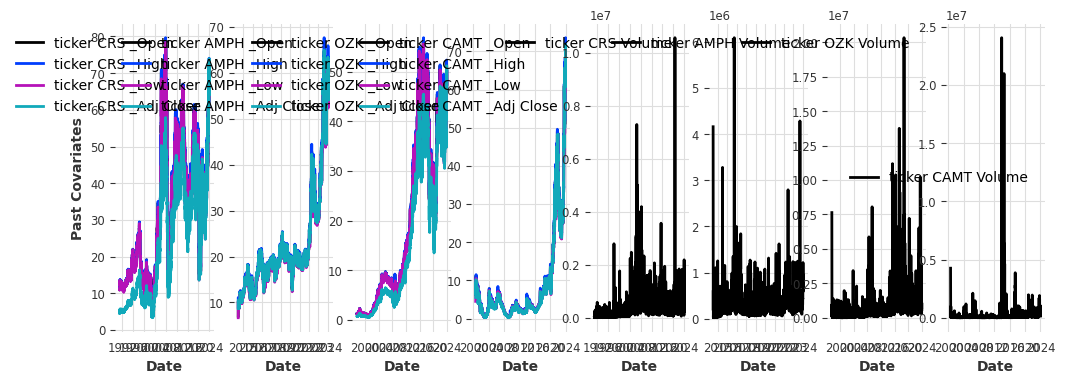

In [29]:
import matplotlib.pyplot as plt


n_plot_samples = 4
# plot sample of past covariates
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples*2, figsize=(12, 4))
for i,t in enumerate(past_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {past_covariates[t].columns}')
        past_covariates[t].drop_columns(['Volume']).plot(label=f'ticker {t} ', ax=axes[i])
        past_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes[n_plot_samples+i])

axes[0].set_ylabel('Past Covariates')


## Prepare Past Covariates

### Add sales and earnings calendar (past and forward looking) to past covariates
* Note: Research further if the data feed provides forward looking estimates at early enough dates to be seen by the model during training. It appears that some forward looking estimates are provided with a date column with value after the actual date they have become avaible.

In [30]:
import pandas as pd

earnings_loaded_df = pd.read_csv('data/earnings_calendar.csv.bz2')
print(earnings_loaded_df)

      symbol        date     eps  epsEstimated time       revenue  \
0       AAON  2024-11-04     NaN           NaN  amc           NaN   
1       AAON  2024-08-01     NaN           NaN  amc           NaN   
2       AAON  2024-05-02     NaN           NaN  amc           NaN   
3       AAON  2024-02-26     NaN          0.53  bmo           NaN   
4       AAON  2023-11-06  0.6400          0.55  amc  3.119700e+08   
...      ...         ...     ...           ...  ...           ...   
26172    ZTS  2012-03-31  0.2311           NaN  bmo  1.047000e+09   
26173    ZTS  2011-12-31  0.0180           NaN  bmo  1.127000e+09   
26174    ZTS  2011-09-30  0.1880           NaN  bmo  1.049000e+09   
26175    ZTS  2011-06-30  0.1320           NaN  bmo  1.074000e+09   
26176    ZTS  2011-03-31  0.1583           NaN  bmo  9.830000e+08   

       revenueEstimated updatedFromDate fiscalDateEnding  
0                   NaN      2024-01-13       2024-09-30  
1                   NaN      2024-01-13       2024-06

In [31]:
earnings_loaded_df.index.is_unique

True

In [32]:
earnings_loaded_df.index

RangeIndex(start=0, stop=26177, step=1)

In [33]:
len(earnings_loaded_df.index)

26177

In [34]:
earnings_loaded_df['date'] = pd.to_datetime(earnings_loaded_df['date'])

In [35]:
earnings_unique = earnings_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [36]:
assert not earnings_unique.duplicated().any()

In [37]:
earnings_unique

,symbol,date,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate,fiscalDateEnding
0,AAON,2024-11-04,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-09-30
1,AAON,2024-08-01,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-06-30
2,AAON,2024-05-02,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-03-30
3,AAON,2024-02-26,NaN,0.53,bmo,NaN,294360000.0,2024-01-13,2023-12-30
4,AAON,2023-11-06,0.6400,0.55,amc,3.119700e+08,294360000.0,2024-01-13,2023-09-30
...,...,...,...,...,...,...,...,...,...
26172,ZTS,2012-03-31,0.2311,NaN,bmo,1.047000e+09,NaN,2023-12-04,2012-03-31
26173,ZTS,2011-12-31,0.0180,NaN,bmo,1.127000e+09,NaN,2023-12-04,2011-12-31
26174,ZTS,2011-09-30,0.1880,NaN,bmo,1.049000e+09,NaN,2023-12-04,2011-09-30
26175,ZTS,2011-06-30,0.1320,NaN,bmo,1.074000e+09,NaN,2023-12-04,2011-06-30


In [38]:
earnings_unique = earnings_unique.set_index(keys=['symbol', 'date'])

In [39]:
earnings_unique

eps  epsEstimated time       revenue  revenueEstimated  \
symbol date                                                                    
AAON   2024-11-04     NaN           NaN  amc           NaN               NaN   
       2024-08-01     NaN           NaN  amc           NaN               NaN   
       2024-05-02     NaN           NaN  amc           NaN               NaN   
       2024-02-26     NaN          0.53  bmo           NaN       294360000.0   
       2023-11-06  0.6400          0.55  amc  3.119700e+08       294360000.0   
...                   ...           ...  ...           ...               ...   
ZTS    2012-03-31  0.2311           NaN  bmo  1.047000e+09               NaN   
       2011-12-31  0.0180           NaN  bmo  1.127000e+09               NaN   
       2011-09-30  0.1880           NaN  bmo  1.049000e+09               NaN   
       2011-06-30  0.1320           NaN  bmo  1.074000e+09               NaN   
       2011-03-31  0.1583           NaN  bmo  9.830000e+08               NaN   

                  updatedFromDate fiscalDateEnding  
symbol date                                         
AAON   2024-11-04      2024-01-13       2024-09-30  
       2024-08-01      2024-01-13       2024-06-30  
       2024-05-02      2024-01-13       2024-03-30  
       2024-02-26      2024-01-13       2023-12-30  
       2023-11-06      2024-01-13       2023-09-30  
...                           ...              ...  
ZTS    2012-03-31      2023-12-04       2012-03-31  
       2011-12-31      2023-12-04       2011-12-31  
       2011-09-30      2023-12-04       2011-09-30  
       2011-06-30      2023-12-04       2011-06-30  
       2011-03-31      2023-12-04       2011-03-31  

[26167 rows x 7 columns]

In [40]:
assert earnings_unique.index.has_duplicates == False

In [41]:
# check if data for a given symbol was saved and loaded as expected
earnings_unique.xs('LRN', level='symbol')

,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate,fiscalDateEnding
date,,,,,,,
2024-10-22,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-09-30
2024-08-13,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-06-30
2024-04-23,NaN,NaN,amc,NaN,NaN,2024-01-13,2024-03-30
2024-01-23,NaN,1.34,amc,NaN,500850000.0,2024-01-13,2023-12-30
2023-10-24,0.11000,-0.35,amc,480181000.0,451150000.0,2024-01-13,2023-09-30
...,...,...,...,...,...,...,...
2006-06-30,0.17150,NaN,amc,29225000.0,NaN,2023-12-04,2006-06-30
2006-03-31,0.17200,NaN,amc,29226000.0,NaN,2023-12-04,2006-03-31
2005-12-31,0.17200,NaN,amc,29226000.0,NaN,2023-12-04,2005-12-31


In [42]:
print(earnings_unique.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated updatedFromDate fiscalDateEnding
date                                                                                               
2024-10-22   NaN           NaN  amc          NaN               NaN      2024-01-13       2024-09-30
2024-08-13   NaN           NaN  amc          NaN               NaN      2024-01-13       2024-06-30
2024-04-23   NaN           NaN  amc          NaN               NaN      2024-01-13       2024-03-30
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08      2024-01-13       2023-12-30
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08      2024-01-13       2023-09-30
2023-08-15  1.01        0.8700  amc  483489000.0      4.607000e+08      2023-12-04       2023-06-30
2023-04-25  1.30        1.0700  amc  470284000.0      4.607000e+08      2023-12-04       2023-03-31
2023-01-24  1.19        1.0400  amc  458435000.0               NaN      2023-12-04       2022-12-31


In [43]:
# get a clean deep copy so it is easier to debug further data cleanup steps
earnings_expanded_df = earnings_unique.copy()

In [44]:
# convert date strings to numerical representation
ufd = pd.to_datetime(earnings_expanded_df['updatedFromDate'])
ufd_year = ufd.dt.year
ufd_month = ufd.dt.month
ufd_day = ufd.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_year', value=ufd_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_month', value=ufd_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_day', value=ufd_day)
earnings_expanded_df.pop('updatedFromDate')


symbol  date      
AAON    2024-11-04    2024-01-13
        2024-08-01    2024-01-13
        2024-05-02    2024-01-13
        2024-02-26    2024-01-13
        2023-11-06    2024-01-13
                         ...    
ZTS     2012-03-31    2023-12-04
        2011-12-31    2023-12-04
        2011-09-30    2023-12-04
        2011-06-30    2023-12-04
        2011-03-31    2023-12-04
Name: updatedFromDate, Length: 26167, dtype: object

In [45]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated fiscalDateEnding  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year
date                                                                                                                                                 
2024-10-22   NaN           NaN  amc          NaN               NaN       2024-09-30                   13                      1                  2024
2024-08-13   NaN           NaN  amc          NaN               NaN       2024-06-30                   13                      1                  2024
2024-04-23   NaN           NaN  amc          NaN               NaN       2024-03-30                   13                      1                  2024
2024-01-23   NaN        1.3400  amc          NaN      5.008500e+08       2023-12-30                   13                      1                  2024
2023-10-24  0.11       -0.3500  amc  480181000.0      4.511500e+08       2023-09-30                 

In [46]:
# convert date strings to numerical representation
fde = pd.to_datetime(earnings_expanded_df['fiscalDateEnding'])
fde_year = fde.dt.year
fde_month = fde.dt.month
fde_day = fde.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_year', value=fde_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_month', value=fde_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_day', value=fde_day)
earnings_expanded_df.pop('fiscalDateEnding')


symbol  date      
AAON    2024-11-04    2024-09-30
        2024-08-01    2024-06-30
        2024-05-02    2024-03-30
        2024-02-26    2023-12-30
        2023-11-06    2023-09-30
                         ...    
ZTS     2012-03-31    2012-03-31
        2011-12-31    2011-12-31
        2011-09-30    2011-09-30
        2011-06-30    2011-06-30
        2011-03-31    2011-03-31
Name: fiscalDateEnding, Length: 26167, dtype: object

In [47]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                     
2024-10-22   NaN           NaN  amc          NaN               NaN                   13                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN  amc          NaN               NaN                   13                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN  amc          NaN               NaN                   13                      1                  2024                    30                       3              

In [48]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
earnings_expanded_df['time'] = earnings_expanded_df['time'].replace(['bmo', 'amc', '--', 'dmh'],
                        [0, 1, -1, -1], inplace=False).astype('int32')



In [49]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

             eps  epsEstimated  time      revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                      
2024-10-22   NaN           NaN     1          NaN               NaN                   13                      1                  2024                    30                       9                   2024
2024-08-13   NaN           NaN     1          NaN               NaN                   13                      1                  2024                    30                       6                   2024
2024-04-23   NaN           NaN     1          NaN               NaN                   13                      1                  2024                    30                       3         

In [50]:
from darts import TimeSeries

type(earnings_expanded_df.index)

pandas.core.indexes.multi.MultiIndex

In [51]:
earnings_expanded_df.index.names

FrozenList(['symbol', 'date'])

In [52]:
earnings_expanded_df.dtypes

eps                       float64
epsEstimated              float64
time                        int32
revenue                   float64
revenueEstimated          float64
updatedFromDate_day         int32
updatedFromDate_month       int32
updatedFromDate_year        int32
fiscalDateEnding_day        int32
fiscalDateEnding_month      int32
fiscalDateEnding_year       int32
dtype: object

In [53]:
# credit for implementation: https://stackoverflow.com/a/39068260/12015435
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))


In [54]:
t_earn = earnings_expanded_df.loc[['LRN']]
t_earn = t_earn.droplevel('symbol')
t_earn.index = pd.to_datetime(t_earn.index)
print(f'index type for {t}: {type(t_earn.index)}')
assert not t_earn.index.duplicated().any()

for i in t_earn.index:
    if not is_business_day(i):
        print(f'earnings record date is not a business day: \n{t_earn.loc[[i]]}')



index type for BLDR: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
earnings record date is not a business day: 
               eps  epsEstimated  time     revenue  revenueEstimated  \
date                                                                   
2007-09-30  0.1201           NaN     1  27196000.0               NaN   

            updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  \
date                                                                           
2007-09-30                    4                     12                  2023   

            fiscalDateEnding_day  fiscalDateEnding_month  \
date                                                       
2007-09-30                    30                       9   

            fiscalDateEnding_year  
date                               
2007-09-30                   2007  
earnings record date is not a business day: 
                eps  epsEstimated  time     revenue  revenueEstimated  \
date           

In [55]:
len(t_earn.index)

78

In [56]:
# align all dates with Business days
from pandas.tseries.offsets import BDay

def to_biz_day(date=None, report_time=None):
    if not is_business_day(date):
        if report_time == 1 or report_time =='amc':
                return date-BDay(n=1)
        else: 
            return date+BDay(n=1)
    else:
         return date

def align_to_business_days(t_earn=None):
    assert not t_earn.index.isnull().any()
    new_index = t_earn.index.map(lambda x : to_biz_day(date=x, report_time=t_earn.at[x, 'time']))
    t_earn.index = new_index
    if t_earn.index.isnull().any():
         print(t_earn[t_earn.index.isnull()])
    for i in t_earn.index:
        assert is_business_day(i)
    return t_earn


In [57]:
# backfill quarterly earnigs and revenue estimates so that the model can see the next quarter's estimates during the previou s quarter days

def back_fill_earn_estimates(t_earn=None):
    t_earn['time'].bfill(inplace=True)
    t_earn['epsEstimated'].bfill(inplace=True)
    t_earn['revenueEstimated'].bfill(inplace=True)
    t_earn['fiscalDateEnding_day'].bfill(inplace=True)
    t_earn['fiscalDateEnding_month'].bfill(inplace=True)
    t_earn['fiscalDateEnding_year'].bfill(inplace=True)
    return t_earn



In [58]:
# convert earnings dataframe to series

t_earn_series = {}
for t in list(ticker_series.keys()):
    print(f'ticker: {t}')
    t_earn = earnings_expanded_df.loc[[t]].copy()
    t_earn = t_earn.droplevel('symbol')
    t_earn.index = pd.to_datetime(t_earn.index)
    print(f'index type for {t}: {type(t_earn.index)}')
    assert not t_earn.index.duplicated().any()
    assert not t_earn.index.isnull().any()
    t_earn = align_to_business_days(t_earn)
    print(f't_earn freq: {t_earn.index}')
    tes_tmp = TimeSeries.from_dataframe(t_earn, freq='B', fill_missing_dates=True)
    t_earn = back_fill_earn_estimates(t_earn=tes_tmp.pd_dataframe())
    tes = TimeSeries.from_dataframe(t_earn, fillna_value=-1)
    assert len(tes.gaps()) == 0
    t_earn_series[t] = tes


ticker: CRS
index type for CRS: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
t_earn freq: DatetimeIndex(['2024-10-24', '2024-07-25', '2024-04-25', '2024-01-25',
               '2023-10-26', '2023-07-27', '2023-04-27', '2023-01-26',
               '2022-10-27', '2022-07-28',
               ...
               '1991-12-31', '1991-09-30', '1991-07-01', '1991-04-01',
               '1990-12-31', '1990-10-01', '1990-07-02', '1990-04-02',
               '1990-01-01', '1989-10-02'],
              dtype='datetime64[ns]', name='date', length=141, freq=None)
ticker: AMPH
index type for AMPH: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
t_earn freq: DatetimeIndex(['2024-11-06', '2024-08-06', '2024-05-07', '2024-02-27',
               '2023-11-08', '2023-08-08', '2023-05-09', '2023-02-28',
               '2022-11-07', '2022-08-08', '2022-05-09', '2022-03-10',
               '2021-11-08', '2021-08-09', '2021-05-06', '2021-03-15',
               '2020-11-06', '2020-08-06', '2020-05-

In [59]:
t

'BLDR'

In [60]:
t_earn


component,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,updatedFromDate_month,updatedFromDate_year,fiscalDateEnding_day,fiscalDateEnding_month,fiscalDateEnding_year
date,,,,,,,,,,,
2005-03-31,-0.68712,0.63,1.0,509342000.0,507150000.0,4.0,12.0,2023.0,31.0,3.0,2005.0
2005-04-01,NaN,0.63,1.0,NaN,507150000.0,NaN,NaN,NaN,30.0,6.0,2005.0
2005-04-04,NaN,0.63,1.0,NaN,507150000.0,NaN,NaN,NaN,30.0,6.0,2005.0
2005-04-05,NaN,0.63,1.0,NaN,507150000.0,NaN,NaN,NaN,30.0,6.0,2005.0
2005-04-06,NaN,0.63,1.0,NaN,507150000.0,NaN,NaN,NaN,30.0,6.0,2005.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,30.0,9.0,2024.0
2024-10-25,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,30.0,9.0,2024.0
2024-10-28,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,30.0,9.0,2024.0


In [61]:
print(t_earn.tail(n=330).to_string(index=True))

component    eps  epsEstimated  time       revenue  revenueEstimated  updatedFromDate_day  updatedFromDate_month  updatedFromDate_year  fiscalDateEnding_day  fiscalDateEnding_month  fiscalDateEnding_year
date                                                                                                                                                                                                       
2023-07-27   NaN          2.51   0.0           NaN      4.777060e+09                  NaN                    NaN                   NaN                  30.0                     6.0                 2023.0
2023-07-28   NaN          2.51   0.0           NaN      4.777060e+09                  NaN                    NaN                   NaN                  30.0                     6.0                 2023.0
2023-07-31   NaN          2.51   0.0           NaN      4.777060e+09                  NaN                    NaN                   NaN                  30.0                     6.0    

In [62]:
t_earn.index

DatetimeIndex(['2005-03-31', '2005-04-01', '2005-04-04', '2005-04-05',
               '2005-04-06', '2005-04-07', '2005-04-08', '2005-04-11',
               '2005-04-12', '2005-04-13',
               ...
               '2024-10-17', '2024-10-18', '2024-10-21', '2024-10-22',
               '2024-10-23', '2024-10-24', '2024-10-25', '2024-10-28',
               '2024-10-29', '2024-10-30'],
              dtype='datetime64[ns]', name='date', length=5110, freq='B')

In [63]:
tes.pd_dataframe()

component,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,updatedFromDate_month,updatedFromDate_year,fiscalDateEnding_day,fiscalDateEnding_month,fiscalDateEnding_year
date,,,,,,,,,,,
2005-03-31,-0.68712,0.63,1.0,509342000.0,507150000.0,4.0,12.0,2023.0,31.0,3.0,2005.0
2005-04-01,-1.00000,0.63,1.0,-1.0,507150000.0,-1.0,-1.0,-1.0,30.0,6.0,2005.0
2005-04-04,-1.00000,0.63,1.0,-1.0,507150000.0,-1.0,-1.0,-1.0,30.0,6.0,2005.0
2005-04-05,-1.00000,0.63,1.0,-1.0,507150000.0,-1.0,-1.0,-1.0,30.0,6.0,2005.0
2005-04-06,-1.00000,0.63,1.0,-1.0,507150000.0,-1.0,-1.0,-1.0,30.0,6.0,2005.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,-1.00000,-1.00,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,30.0,9.0,2024.0
2024-10-25,-1.00000,-1.00,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,30.0,9.0,2024.0
2024-10-28,-1.00000,-1.00,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,30.0,9.0,2024.0


In [64]:
t_earn_series

{'CRS': <TimeSeries (DataArray) (date: 9149, component: 11, sample: 1)>
 array([[[ 2.150e-01],
         [ 1.600e-01],
         [ 0.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 1.989e+03]],
 
        [[-1.000e+00],
         [ 1.600e-01],
         [ 0.000e+00],
         ...,
         [ 3.100e+01],
         [ 1.200e+01],
         [ 1.989e+03]],
 
        [[-1.000e+00],
         [ 1.600e-01],
         [ 0.000e+00],
         ...,
 ...
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [ 0.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [ 0.000e+00],
         ...,
         [ 3.000e+01],
         [ 9.000e+00],
         [ 2.024e+03]]])
 Coordinates:
   * date       (date) datetime64[ns] 1989-10-02 1989-10-03 ... 2024-10-24
   * component  (component) object 'eps' ... '

In [65]:
# stack sales and earnigns to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    print(f'stacking future covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_earn_series[t])
    earn_sliced = t_earn_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(earn_sliced)
    print(f'past covariates for {t} including earnings calendar: \n{new_past_covs[t].components}')
    print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



stacking future covs for CRS
past covariates for CRS including earnings calendar: 
Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated',
       'time', 'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year'],
      dtype='object', name='component')
past covariates for CRS start time: 1991-01-01 00:00:00, end time: 2024-01-12 00:00:00
past covariates for CRS sample: 
component     Open      High      Low  Adj Close   Volume  eps  epsEstimated  \
Date                                                                           
1991-01-01  11.125  11.21875  11.0625   4.632128  22800.0 -1.0          0.16   

component   time  revenue  revenueEstimated  updatedFromDate_day  \
Date                                                               
1991-01-01   0.0     -1.0      1.862348e+08                 -1.0   

component   updatedFromDate

In [66]:
past_covariates = new_past_covs

In [67]:
t

'BLDR'

In [68]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2005-06-28 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [69]:
print(f'past covariates with price and earnings sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with price and earnings sample: component        Open    High        Low  Adj Close    Volume    eps  \
Date                                                                   
2005-06-28  15.200000  15.990  15.200000  15.990000  521800.0 -1.000   
2005-06-29  16.000000  16.080  15.800000  16.030001  230300.0 -1.000   
2005-06-30  16.000000  16.250  15.900000  16.200001  479400.0  0.657   
2005-07-01  16.299999  16.400  16.139999  16.240000  148000.0 -1.000   
2005-07-04  16.275000  16.325  16.070000  16.145000  242250.0 -1.000   

component   epsEstimated  time      revenue  revenueEstimated  \
Date                                                            
2005-06-28          0.63   1.0         -1.0       507150000.0   
2005-06-29          0.63   1.0         -1.0       507150000.0   
2005-06-30          0.63   1.0  618600000.0       507150000.0   
2005-07-01          0.63   0.0         -1.0       507150000.0   
2005-07-04          0.63   0.0         -1.0       5071500

In [70]:
t_earn_series[t].start_time(), t_earn_series[t].end_time()

(Timestamp('2005-03-31 00:00:00'), Timestamp('2024-10-30 00:00:00'))

### Add key metrics to past covariates

In [71]:
kms_file = 'data/keymetrics_history.csv.bz2'


In [72]:
import pandas as pd

kms_loaded_df = pd.read_csv(kms_file)
print(kms_loaded_df)

      symbol        date  calendarYear period  revenuePerShare  \
0        SSD  2023-09-30          2023     Q3        13.593701   
1        SSD  2023-06-30          2023     Q2        14.005015   
2        SSD  2023-03-31          2023     Q1        12.542361   
3        SSD  2022-12-31          2022     Q4        11.172179   
4        SSD  2022-09-30          2022     Q3        12.932100   
...      ...         ...           ...    ...              ...   
25625   ARVN  2018-03-31          2018     Q1         0.198178   
25626   ARVN  2017-12-31          2017     Q4         0.124075   
25627   ARVN  2017-09-30          2017     Q3         0.080497   
25628   ARVN  2017-06-30          2017     Q2         0.879481   
25629   ARVN  2017-03-31          2017     Q1         0.879481   

       netIncomePerShare  operatingCashFlowPerShare  freeCashFlowPerShare  \
0               2.437630                   0.000000              0.000000   
1               2.512620                   4.553235  

In [73]:
assert kms_loaded_df.index.is_unique

In [74]:
kms_loaded_df.index

RangeIndex(start=0, stop=25630, step=1)

In [75]:
len(kms_loaded_df.index)

25630

In [76]:
kms_loaded_df['date'] = pd.to_datetime(kms_loaded_df['date'])

In [77]:
kms_unique = kms_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [78]:
assert not kms_unique.duplicated().any()

In [79]:
kms_unique

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
0,SSD,2023-09-30,2023,Q3,13.593701,2.437630,0.000000,0.000000,13.380967,39.122911,...,96557000.0,513307500.0,54.483075,28.852564,152.776520,1.651889,3.119307,0.589096,0.062307,0.000000
1,SSD,2023-06-30,2023,Q2,14.005015,2.512620,4.553235,4.104197,9.561555,37.013101,...,96574500.0,549301000.0,58.423190,28.396751,151.541723,1.540484,3.169377,0.593896,0.067885,-0.449038
2,SSD,2023-03-31,2023,Q1,12.542361,2.064163,0.069420,-0.370805,5.926801,34.907510,...,96571500.0,566617000.0,57.202365,30.463712,184.259396,1.573362,2.954335,0.488442,0.059132,-0.440225
3,SSD,2022-12-31,2022,Q4,11.172179,1.353119,3.204571,2.602015,14.128629,33.370008,...,98243500.0,548410500.0,50.925231,32.024534,182.247652,1.767297,2.810345,0.493834,0.040549,-0.602556
4,SSD,2022-09-30,2022,Q3,12.932100,2.061126,2.918389,2.690842,7.223554,31.241796,...,105807000.0,539932000.0,54.366039,28.718926,157.216657,1.655445,3.133822,0.572458,0.065973,-0.227548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25625,ARVN,2018-03-31,2018,Q1,0.198178,-0.200194,0.930897,0.900092,5.435910,2.480791,...,1281630.5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.080698,-0.030805
25626,ARVN,2017-12-31,2017,Q4,0.124075,-0.228056,1.358169,1.337208,1.889431,0.011860,...,NaN,NaN,911.109535,0.000000,0.000000,0.098781,0.000000,0.000000,-19.229780,-0.020961
25627,ARVN,2017-09-30,2017,Q3,0.080497,-0.308572,-0.358904,-0.358676,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000229
25628,ARVN,2017-06-30,2017,Q2,0.879481,-3.519372,-4.494133,-4.544222,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.050089


In [80]:
kms_unique = kms_unique.set_index(keys=['symbol', 'date'])

In [81]:
kms_unique

calendarYear period  revenuePerShare  netIncomePerShare  \
symbol date                                                                  
SSD    2023-09-30          2023     Q3        13.593701           2.437630   
       2023-06-30          2023     Q2        14.005015           2.512620   
       2023-03-31          2023     Q1        12.542361           2.064163   
       2022-12-31          2022     Q4        11.172179           1.353119   
       2022-09-30          2022     Q3        12.932100           2.061126   
...                         ...    ...              ...                ...   
ARVN   2018-03-31          2018     Q1         0.198178          -0.200194   
       2017-12-31          2017     Q4         0.124075          -0.228056   
       2017-09-30          2017     Q3         0.080497          -0.308572   
       2017-06-30          2017     Q2         0.879481          -3.519372   
       2017-03-31          2017     Q1         0.879481          -3.291460   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
SSD    2023-09-30                   0.000000              0.000000   
       2023-06-30                   4.553235              4.104197   
       2023-03-31                   0.069420             -0.370805   
       2022-12-31                   3.204571              2.602015   
       2022-09-30                   2.918389              2.690842   
...                                      ...                   ...   
ARVN   2018-03-31                   0.930897              0.900092   
       2017-12-31                   1.358169              1.337208   
       2017-09-30                  -0.358904             -0.358676   
       2017-06-30                  -4.494133             -4.544222   
       2017-03-31                  -3.728831             -3.985769   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
SSD    2023-09-30     13.380967          39.122911                  19.441544   
       2023-06-30      9.561555          37.013101                  16.815604   
       2023-03-31      5.926801          34.907510                  14.563201   
       2022-12-31     14.128629          33.370008                  13.013107   
       2022-09-30      7.223554          31.241796                  12.590381   
...                         ...                ...                        ...   
ARVN   2018-03-31      5.435910           2.480791                   2.480791   
       2017-12-31      1.889431           0.011860                   0.011860   
       2017-09-30           NaN                NaN                        NaN   
       2017-06-30           NaN                NaN                        NaN   
       2017-03-31     18.738486          12.694176                   0.000000   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
SSD    2023-09-30                   39.122911  ...       96557000.0   
       2023-06-30                   37.013101  ...       96574500.0   
       2023-03-31                   34.907510  ...       96571500.0   
       2022-12-31                   33.370008  ...       98243500.0   
       2022-09-30                   31.241796  ...      105807000.0   
...                                       ...  ...              ...   
ARVN   2018-03-31                    2.480791  ...        1281630.5   
       2017-12-31                    0.011860  ...              NaN   
       2017-09-30                         NaN  ...              NaN   
       2017-06-30                         NaN  ...              NaN   
       2017-03-31                   12.694176  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                                           

In [82]:
assert kms_unique.index.has_duplicates == False

In [83]:
# check if data for a given symbol was saved and loaded as expected
kms_unique.xs('AAON', level='symbol')

,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
date,,,,,,,,,,,,,,,,,,,,,
2023-09-30,2023,Q3,3.831670,0.590502,0.579780,0.306244,0.002604,8.382388,6.616297,8.382388,...,31063500.0,214957500.0,53.489951,13.747147,98.568015,1.682559,6.546813,0.913075,0.070446,-0.273536
2023-06-30,2023,Q2,5.230073,0.841396,1.015175,0.431417,0.096458,12.158279,9.493209,12.158279,...,30885500.0,207493500.0,55.996084,15.262268,102.068138,1.607255,5.896895,0.881764,0.069204,-0.583757
2023-03-31,2023,Q1,4.958054,0.686309,0.089913,-0.449510,0.046886,11.361059,8.646772,11.361059,...,37537000.0,199259000.0,59.586468,14.091653,95.138798,1.510410,6.386760,0.945986,0.060409,-0.539424
2022-12-31,2022,Q4,4.775174,0.729561,0.335803,0.102519,0.102238,10.516606,7.768928,10.516606,...,47063000.0,187913500.0,50.306012,23.266158,101.697234,1.789051,3.868279,0.884980,0.069372,-0.233284
2022-09-30,2022,Q3,4.561503,0.516552,0.845985,0.576005,0.201898,9.849672,7.078250,9.849672,...,42401000.0,170444500.0,54.015952,24.716520,89.935937,1.666174,3.641289,1.000712,0.052444,-0.269980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991-03-31,1991,Q1,0.090495,-0.001588,0.014289,0.014289,-0.001588,0.025402,0.025402,0.025402,...,1450000.0,4950000.0,56.842105,21.600000,88.200000,1.583333,4.166667,1.020408,-0.062500,0.000000
1990-12-31,1990,Q4,0.118167,0.000000,0.007034,0.005627,0.005627,0.023915,0.023915,0.023915,...,2250000.0,5900000.0,50.357143,20.400000,60.000000,1.787234,4.411765,1.500000,0.000000,-0.001407
1990-09-30,1990,Q3,0.177603,0.007034,-0.015826,-0.024618,0.000000,0.029894,0.029894,0.029894,...,2750000.0,6500000.0,43.663366,31.898734,77.468354,2.061224,2.821429,1.161765,0.235294,-0.008792


In [84]:
kms_loaded_df = kms_unique.copy()

In [85]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
kms_loaded_df['period'] = kms_loaded_df['period'].replace(['Q1', 'Q2', 'Q3', 'Q4'],
                        [1, 2, 3, 4], inplace=False).astype('int32')

In [86]:
kms_loaded_df

calendarYear  period  revenuePerShare  netIncomePerShare  \
symbol date                                                                   
SSD    2023-09-30          2023       3        13.593701           2.437630   
       2023-06-30          2023       2        14.005015           2.512620   
       2023-03-31          2023       1        12.542361           2.064163   
       2022-12-31          2022       4        11.172179           1.353119   
       2022-09-30          2022       3        12.932100           2.061126   
...                         ...     ...              ...                ...   
ARVN   2018-03-31          2018       1         0.198178          -0.200194   
       2017-12-31          2017       4         0.124075          -0.228056   
       2017-09-30          2017       3         0.080497          -0.308572   
       2017-06-30          2017       2         0.879481          -3.519372   
       2017-03-31          2017       1         0.879481          -3.291460   

                   operatingCashFlowPerShare  freeCashFlowPerShare  \
symbol date                                                          
SSD    2023-09-30                   0.000000              0.000000   
       2023-06-30                   4.553235              4.104197   
       2023-03-31                   0.069420             -0.370805   
       2022-12-31                   3.204571              2.602015   
       2022-09-30                   2.918389              2.690842   
...                                      ...                   ...   
ARVN   2018-03-31                   0.930897              0.900092   
       2017-12-31                   1.358169              1.337208   
       2017-09-30                  -0.358904             -0.358676   
       2017-06-30                  -4.494133             -4.544222   
       2017-03-31                  -3.728831             -3.985769   

                   cashPerShare  bookValuePerShare  tangibleBookValuePerShare  \
symbol date                                                                     
SSD    2023-09-30     13.380967          39.122911                  19.441544   
       2023-06-30      9.561555          37.013101                  16.815604   
       2023-03-31      5.926801          34.907510                  14.563201   
       2022-12-31     14.128629          33.370008                  13.013107   
       2022-09-30      7.223554          31.241796                  12.590381   
...                         ...                ...                        ...   
ARVN   2018-03-31      5.435910           2.480791                   2.480791   
       2017-12-31      1.889431           0.011860                   0.011860   
       2017-09-30           NaN                NaN                        NaN   
       2017-06-30           NaN                NaN                        NaN   
       2017-03-31     18.738486          12.694176                   0.000000   

                   shareholdersEquityPerShare  ...  averagePayables  \
symbol date                                    ...                    
SSD    2023-09-30                   39.122911  ...       96557000.0   
       2023-06-30                   37.013101  ...       96574500.0   
       2023-03-31                   34.907510  ...       96571500.0   
       2022-12-31                   33.370008  ...       98243500.0   
       2022-09-30                   31.241796  ...      105807000.0   
...                                       ...  ...              ...   
ARVN   2018-03-31                    2.480791  ...        1281630.5   
       2017-12-31                    0.011860  ...              NaN   
       2017-09-30                         NaN  ...              NaN   
       2017-06-30                         NaN  ...              NaN   
       2017-03-31                   12.694176  ...              NaN   

                   averageInventory  daysSalesOutstanding  \
symbol date                              

In [87]:
from darts import TimeSeries

type(kms_loaded_df.index)

pandas.core.indexes.multi.MultiIndex

In [88]:
kms_loaded_df.index.names

FrozenList(['symbol', 'date'])

In [89]:
kms_loaded_df.dtypes

calendarYear                                int64
period                                      int32
revenuePerShare                           float64
netIncomePerShare                         float64
operatingCashFlowPerShare                 float64
freeCashFlowPerShare                      float64
cashPerShare                              float64
bookValuePerShare                         float64
tangibleBookValuePerShare                 float64
shareholdersEquityPerShare                float64
interestDebtPerShare                      float64
marketCap                                 float64
enterpriseValue                           float64
peRatio                                   float64
priceToSalesRatio                         float64
pocfratio                                 float64
pfcfRatio                                 float64
pbRatio                                   float64
ptbRatio                                  float64
evToSales                                 float64


In [90]:
def df_index_to_biz_days(df=None):
    new_index = df.index.map(lambda x : to_biz_day(date=x))
    df.index = new_index
    return df



In [91]:

def pad_kms(kms_series=None, price_series=None):
    """ 
    Pad a ticker's key metrics to align with price data
    """
    updated_kms_series = None
    if kms_series.end_time() < price_series.end_time():
        print(f'ticker {t} kms end time is before ticker price series end time: {kms_series.end_time()} < {price_series.end_time()}')
        tkms_df = kms_series.pd_dataframe()
        new_kms_df = tkms_df.reindex(price_series.pd_dataframe().index, method='ffill', copy=True)
        new_kms_ser = TimeSeries.from_dataframe(new_kms_df, freq='B', fillna_value=-1)
        print(f'ticker {t} kms end time after reindex: {new_kms_ser.end_time()}')
        updated_kms_series = new_kms_ser
    else:
        updated_kms_series = kms_series
    if kms_series.start_time() > price_series.start_time():
        print(f'ticker {t} kms start time is after ticker price series start time: {kms_series.start_time()} > {price_series.start_time()}')
    return updated_kms_series



In [92]:
t_kms_series = {}
for t in list(ticker_series.keys()):
    print(f'ticker {t}')
    kms_df = kms_loaded_df.loc[[t]].copy()
    print(f'ticker_series[{t}] start time, end time: {ticker_series[t].start_time()}, {ticker_series[t].end_time()}')
    print(f'kms_ser_df start time, end time: {kms_df.index[0]}, {kms_df.index[-1]}')
    kms_df = kms_df.droplevel('symbol')
    kms_df.index = pd.to_datetime(kms_df.index)
    # print(f'index type for {t}: {type(t_kms.index)}')
    assert not kms_df.index.duplicated().any()
    # print(f'{t} earnings: \n{t_kms.columns}')
    kms_df = df_index_to_biz_days(kms_df)
    tkms_series_tmp = TimeSeries.from_dataframe(kms_df, freq='B', fill_missing_dates=True)
    print(f'kms_series_tmp start time, end time: {tkms_series_tmp.start_time()}, {tkms_series_tmp.end_time()}')
    kms_df_ext =tkms_series_tmp.pd_dataframe()
    kms_df_ext.ffill(inplace=True)
    kms_ser = TimeSeries.from_dataframe(kms_df, freq='B', fillna_value=-1)
    kms_ser_padded = pad_kms(kms_series=kms_ser, price_series=ticker_series[t])
    print(f'kms_ser_padded start time, end time: {kms_ser_padded.start_time()}, {kms_ser_padded.end_time()}')
    assert len(kms_ser_padded.gaps()) == 0, f'found gaps in tmks series: \n{kms_ser_padded.gaps()}'
    t_kms_series[t] = kms_ser_padded


ticker CRS
ticker_series[CRS] start time, end time: 1991-01-01 00:00:00, 2024-01-12 00:00:00
kms_ser_df start time, end time: ('CRS', Timestamp('2023-09-30 00:00:00')), ('CRS', Timestamp('1985-09-30 00:00:00'))
kms_series_tmp start time, end time: 1985-09-30 00:00:00, 2023-10-02 00:00:00
ticker CRS kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-12 00:00:00
ticker CRS kms end time after reindex: 2024-01-12 00:00:00
kms_ser_padded start time, end time: 1991-01-01 00:00:00, 2024-01-12 00:00:00
ticker AMPH
ticker_series[AMPH] start time, end time: 2014-06-25 00:00:00, 2024-01-12 00:00:00
kms_ser_df start time, end time: ('AMPH', Timestamp('2023-09-30 00:00:00')), ('AMPH', Timestamp('2013-03-31 00:00:00'))
kms_series_tmp start time, end time: 2013-04-01 00:00:00, 2023-10-02 00:00:00
ticker AMPH kms end time is before ticker price series end time: 2023-10-02 00:00:00 < 2024-01-12 00:00:00
ticker AMPH kms end time after reindex: 2024-01-12 00:00:00
kms_ser_

In [93]:
t_kms_series

{'CRS': <TimeSeries (DataArray) (Date: 8619, component: 59, sample: 1)>
 array([[[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
         [-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00]],
 
        [[-1.00000000e+00],
         [-1.00000000e+00],
         [-1.00000000e+00],
         ...,
 ...
         ...,
         [ 7.46851564e-01],
         [ 3.07143357e-02],
         [-4.47154472e-01]],
 
        [[ 2.02400000e+03],
         [ 1.00000000e+00],
         [ 1.32500000e+01],
         ...,
         [ 7.46851564e-01],
         [ 3.07143357e-02],
         [-4.47154472e-01]],
 
        [[ 2.02400000e+03],
         [ 1.00000000e+00],
         [ 1.32500000e+01],
         ...,
         [ 7.46851564e-01],
         [ 3.07143357e-02],
         [-4.47

In [94]:
t

'BLDR'

In [95]:
kms_df

,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
date,,,,,,,,,,,,,,,,,,,,,
2023-10-02,2023,3,36.397280,3.623919,5.213370,4.045530,0.707161,36.769909,-2.321681,36.769909,...,1.047029e+09,1.346881e+09,40.760143,31.453869,40.578905,2.208039,2.861333,2.217901,0.098557,-1.167840
2023-06-30,2023,2,35.667011,3.186553,3.081865,2.093773,0.703403,34.195642,-4.490073,34.195642,...,1.000452e+09,1.349206e+09,40.839272,32.576235,41.787607,2.203761,2.762750,2.153749,0.093186,-0.988092
2023-03-31,2023,1,28.330055,2.435079,4.773925,4.003210,1.053497,33.976042,-2.416009,33.976042,...,8.712085e+08,1.381180e+09,40.573438,33.641446,47.873721,2.218200,2.675271,1.879946,0.071670,-0.770715
2023-01-02,2022,4,26.905193,2.374123,5.997561,5.164571,0.496697,30.640689,-0.279279,30.640689,...,9.457365e+08,1.592538e+09,38.556499,25.174820,44.685957,2.334237,3.575001,2.014056,0.077483,-0.832990
2022-09-30,2022,3,37.096775,4.751862,9.663291,9.111468,0.547180,33.640053,0.862184,33.640053,...,1.176728e+09,1.912115e+09,38.020843,26.134638,42.249975,2.367123,3.443706,2.130179,0.141256,-0.551822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-03-31,2006,1,16.290708,0.534641,0.105611,-0.062962,0.901760,5.422182,0.910201,5.422182,...,1.401785e+08,1.551375e+08,39.104934,31.287928,33.037361,2.301500,2.876509,2.724189,0.098602,-0.168573
2006-01-02,2005,4,15.660365,0.539650,0.781979,0.584540,0.850643,4.736294,-4.287669,4.736294,...,1.445100e+08,1.486230e+08,37.805977,27.447291,32.035992,2.380576,3.279012,2.809340,0.113939,-0.197439
2005-09-30,2005,3,18.065034,0.780655,1.832048,1.627178,0.952816,4.192977,-4.953939,4.192977,...,1.542660e+08,1.514180e+08,39.242194,30.572572,28.071470,2.293450,2.943815,3.206102,0.186182,-0.204870


In [96]:
kms_ser_padded.pd_dataframe()

component,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-28,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2005-06-29,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2005-06-30,2005.0,2.0,21.890439,0.713439,1.135925,0.788742,0.140097,4.232010,-7.306297,4.232010,...,1.382355e+08,1.534555e+08,39.306547,28.667644,30.120752,2.289695,3.139428,2.987973,0.168582,-0.347182
2005-07-01,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2005-07-04,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,2023.0,3.0,36.397280,3.623919,5.213370,4.045530,0.707161,36.769909,-2.321681,36.769909,...,1.047029e+09,1.346881e+09,40.760143,31.453869,40.578905,2.208039,2.861333,2.217901,0.098557,-1.167840
2024-01-09,2023.0,3.0,36.397280,3.623919,5.213370,4.045530,0.707161,36.769909,-2.321681,36.769909,...,1.047029e+09,1.346881e+09,40.760143,31.453869,40.578905,2.208039,2.861333,2.217901,0.098557,-1.167840
2024-01-10,2023.0,3.0,36.397280,3.623919,5.213370,4.045530,0.707161,36.769909,-2.321681,36.769909,...,1.047029e+09,1.346881e+09,40.760143,31.453869,40.578905,2.208039,2.861333,2.217901,0.098557,-1.167840


In [97]:
kms_ser_padded.pd_dataframe()

component,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,tangibleBookValuePerShare,shareholdersEquityPerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
Date,,,,,,,,,,,,,,,,,,,,,
2005-06-28,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2005-06-29,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2005-06-30,2005.0,2.0,21.890439,0.713439,1.135925,0.788742,0.140097,4.232010,-7.306297,4.232010,...,1.382355e+08,1.534555e+08,39.306547,28.667644,30.120752,2.289695,3.139428,2.987973,0.168582,-0.347182
2005-07-01,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2005-07-04,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,2023.0,3.0,36.397280,3.623919,5.213370,4.045530,0.707161,36.769909,-2.321681,36.769909,...,1.047029e+09,1.346881e+09,40.760143,31.453869,40.578905,2.208039,2.861333,2.217901,0.098557,-1.167840
2024-01-09,2023.0,3.0,36.397280,3.623919,5.213370,4.045530,0.707161,36.769909,-2.321681,36.769909,...,1.047029e+09,1.346881e+09,40.760143,31.453869,40.578905,2.208039,2.861333,2.217901,0.098557,-1.167840
2024-01-10,2023.0,3.0,36.397280,3.623919,5.213370,4.045530,0.707161,36.769909,-2.321681,36.769909,...,1.047029e+09,1.346881e+09,40.760143,31.453869,40.578905,2.208039,2.861333,2.217901,0.098557,-1.167840


In [98]:
# for c in kms_ser_padded.columns:
#    if len(kms_ser_padded[c].gaps()) > 0:
#        print(f'{c} NaNs: {len(kms_ser_padded[c].gaps())}')
#        print(kms_ser_padded[c].gaps())




In [99]:
# stack key metrics to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    print(f'stacking kms covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_kms_series[t])
    kms_sliced = t_kms_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(kms_sliced)
    print(f'past covariates for {t} including key metrics: \n{new_past_covs[t].components}')
    print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    # print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



stacking kms covs for CRS
past covariates for CRS including key metrics: 
Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated',
       'time', 'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', 'calendarYear',
       'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQu

In [100]:
past_covariates = new_past_covs

In [101]:
t

'BLDR'

In [102]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('2005-06-28 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [103]:
print(f'past covariates with key metrics sample: \n{past_covariates[t][0:5].pd_dataframe()}')


past covariates with key metrics sample: 
component        Open    High        Low  Adj Close    Volume    eps  \
Date                                                                   
2005-06-28  15.200000  15.990  15.200000  15.990000  521800.0 -1.000   
2005-06-29  16.000000  16.080  15.800000  16.030001  230300.0 -1.000   
2005-06-30  16.000000  16.250  15.900000  16.200001  479400.0  0.657   
2005-07-01  16.299999  16.400  16.139999  16.240000  148000.0 -1.000   
2005-07-04  16.275000  16.325  16.070000  16.145000  242250.0 -1.000   

component   epsEstimated  time      revenue  revenueEstimated  ...  \
Date                                                           ...   
2005-06-28          0.63   1.0         -1.0       507150000.0  ...   
2005-06-29          0.63   1.0         -1.0       507150000.0  ...   
2005-06-30          0.63   1.0  618600000.0       507150000.0  ...   
2005-07-01          0.63   0.0         -1.0       507150000.0  ...   
2005-07-04          0.63   0.0   

In [104]:
t_kms_series[t].start_time(), t_kms_series[t].end_time()

(Timestamp('2005-06-28 00:00:00'), Timestamp('2024-01-12 00:00:00'))

### Add broad market indicators to past covariates

In [105]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# UPDATE: Do not drop close as it has relevant information on the relationships between Open, High, Low, Close and Adj Close
# drop Close as redundand
# broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

,^R2ESC_Open,^R2ESC_High,^R2ESC_Low,^R2ESC_Close,^R2ESC_Adj Close,^R2ESC_Volume,^SPXEW_Open,^SPXEW_High,^SPXEW_Low,^SPXEW_Close,...,^SPX_High,^SPX_Low,^SPX_Close,^SPX_Adj Close,^SPX_Volume,DX-Y.NYB_Open,DX-Y.NYB_High,DX-Y.NYB_Low,DX-Y.NYB_Close,DX-Y.NYB_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
1927-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.660000,17.660000,17.660000,17.660000,0.000000e+00,NaN,NaN,NaN,NaN,NaN
1928-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.760000,17.760000,17.760000,17.760000,0.000000e+00,NaN,NaN,NaN,NaN,NaN
1928-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.719999,17.719999,17.719999,17.719999,0.000000e+00,NaN,NaN,NaN,NaN,NaN
1928-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.549999,17.549999,17.549999,17.549999,0.000000e+00,NaN,NaN,NaN,NaN,NaN
1928-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.660000,17.660000,17.660000,17.660000,0.000000e+00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,NaN,NaN,NaN,NaN,NaN,NaN,6317.479980,6385.899902,6303.459961,6385.000000,...,4764.540039,4699.819824,4763.540039,4763.540039,3.742320e+09,102.440002,102.620003,102.080002,102.209999,102.209999
2024-01-09,NaN,NaN,NaN,NaN,NaN,NaN,6384.660156,6384.660156,6334.509766,6354.080078,...,4765.470215,4730.350098,4756.500000,4756.500000,3.529960e+09,102.220001,102.660004,102.110001,102.570000,102.570000
2024-01-10,NaN,NaN,NaN,NaN,NaN,NaN,6354.080078,6375.089844,6333.399902,6364.049805,...,4790.799805,4756.200195,4783.450195,4783.450195,3.498680e+09,102.480003,102.639999,102.339996,102.360001,102.360001


In [106]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='B')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

<TimeSeries (DataArray) (Date: 8619, component: 51, sample: 1)>
array([[[          nan],
        [          nan],
        [          nan],
        ...,
        [  83.01000214],
        [  83.06999969],
        [  83.06999969]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
        [  82.66000366],
        [  82.79000092],
        [  82.79000092]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
...
        ...,
        [ 102.33999634],
        [ 102.36000061],
        [ 102.36000061]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
        [ 102.16000366],
        [ 102.29000092],
        [ 102.29000092]],

       [[4247.75537109],
        [4324.00976562],
        [4239.99316406],
        ...,
        [ 102.08999634],
        [ 102.40000153],
        [ 102.40000153]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-12
  * component  (component) object '^R2ESC_Open' ... 'DX-Y.NYB_Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [107]:
broad_market_series.gaps()


,gap_start,gap_end,gap_size
0,1999-04-02,1999-04-02,1
1,1999-05-31,1999-05-31,1
2,2000-04-21,2000-04-21,1
3,2000-05-29,2000-05-29,1
4,2000-09-04,2000-09-04,1
...,...,...,...
188,2023-07-04,2023-07-04,1
189,2023-09-04,2023-09-04,1
190,2023-11-23,2023-11-23,1
191,2023-12-25,2023-12-25,1


In [108]:

filler = MissingValuesFiller(n_jobs=-1)

series_filled = filler.transform(broad_market_series)
assert len(series_filled.gaps()) == 0

In [109]:
broad_market_series = series_filled


In [110]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


past covariates without broad market indicies: Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated',
       'time', 'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', 'calendarYear',
       'period', 'revenuePerShare', 'netIncomePerShare',
       'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare',
       'bookValuePerShare', 'tangibleBookValuePerShare',
       'shareholdersEquityPerShare', 'interestDebtPerShare', 'marketCap',
       'enterpriseValue', 'peRatio', 'priceToSalesRatio', 'pocfratio',
       'pfcfRatio', 'pbRatio', 'ptbRatio', 'evToSales',
       'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'dividendYield', 'p

In [111]:
print(f'past covariates without broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates without broad market indicies sample: component        Open    High        Low  Adj Close    Volume    eps  \
Date                                                                   
2005-06-28  15.200000  15.990  15.200000  15.990000  521800.0 -1.000   
2005-06-29  16.000000  16.080  15.800000  16.030001  230300.0 -1.000   
2005-06-30  16.000000  16.250  15.900000  16.200001  479400.0  0.657   
2005-07-01  16.299999  16.400  16.139999  16.240000  148000.0 -1.000   
2005-07-04  16.275000  16.325  16.070000  16.145000  242250.0 -1.000   

component   epsEstimated  time      revenue  revenueEstimated  ...  \
Date                                                           ...   
2005-06-28          0.63   1.0         -1.0       507150000.0  ...   
2005-06-29          0.63   1.0         -1.0       507150000.0  ...   
2005-06-30          0.63   1.0  618600000.0       507150000.0  ...   
2005-07-01          0.63   0.0         -1.0       507150000.0  ...   
2005-07-04          0

In [112]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    # print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


In [113]:
print(f'past covariates with broad market indicies components: {past_covariates[t].components}')


past covariates with broad market indicies components: Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated',
       'time', 'revenue', 'revenueEstimated',
       ...
       '^SPX_High', '^SPX_Low', '^SPX_Close', '^SPX_Adj Close', '^SPX_Volume',
       'DX-Y.NYB_Open', 'DX-Y.NYB_High', 'DX-Y.NYB_Low', 'DX-Y.NYB_Close',
       'DX-Y.NYB_Adj Close'],
      dtype='object', name='component', length=126)


In [114]:
print(f'past covariates with broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with broad market indicies sample: component        Open    High        Low  Adj Close    Volume    eps  \
Date                                                                   
2005-06-28  15.200000  15.990  15.200000  15.990000  521800.0 -1.000   
2005-06-29  16.000000  16.080  15.800000  16.030001  230300.0 -1.000   
2005-06-30  16.000000  16.250  15.900000  16.200001  479400.0  0.657   
2005-07-01  16.299999  16.400  16.139999  16.240000  148000.0 -1.000   
2005-07-04  16.275000  16.325  16.070000  16.145000  242250.0 -1.000   

component   epsEstimated  time      revenue  revenueEstimated  ...  \
Date                                                           ...   
2005-06-28          0.63   1.0         -1.0       507150000.0  ...   
2005-06-29          0.63   1.0         -1.0       507150000.0  ...   
2005-06-30          0.63   1.0  618600000.0       507150000.0  ...   
2005-07-01          0.63   0.0         -1.0       507150000.0  ...   
2005-07-04          0.63

In [115]:
# target_series['WRB'].pd_dataframe()

## Prepare Future Covariates

### Add holidays as future covariates

In [116]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

{'CRS': <TimeSeries (DataArray) (Date: 8619, component: 1, sample: 1)>
 array([[[1.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-12
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'AMPH': <TimeSeries (DataArray) (Date: 2493, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2014-06-25 2014-06-26 ... 2024-01-12
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'OZK': <TimeSeries (DataArray) (Date: 6912, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        

### Add forward looking analyst estimates to future covariates

In [117]:
fiscal_freq = {
    'annual': 'Y',
    'quarter': 'Q'
}

fiscal_periods = ['quarter', 'annual']


In [118]:
import pandas as pd

def load_estimates(period=None):
    assert period in fiscal_periods
    est_file = f'data/analyst_estimates_{period}.csv.bz2'
    est_loaded_df = pd.read_csv(est_file)
    assert est_loaded_df.index.is_unique
    print(f'{period} estimates loaded: \n{est_loaded_df}')
    est_loaded_df['date'] = pd.to_datetime(est_loaded_df['date'])
    est_unique = est_loaded_df.drop_duplicates(subset=['symbol', 'date'])
    assert not est_unique.duplicated().any()
    est_unique = est_unique.set_index(keys=['symbol', 'date'])
    assert est_unique.index.has_duplicates == False
    assert est_unique.index.is_unique == True
    print(f'{period} estimates prepared: \n{est_unique}')
    return est_unique


In [119]:
# loaded = load_estimates(period='quarter')

In [120]:

def est_add_future_periods(est_df=None, n_future_periods=None, period=None):
    """
    Prepare time series with concatenated estimates for n_future_periods
    """
    # new_df = pd.DataFrame(index=est_df.index)
    print('est_df', est_df)
    # add fiscalDateEnding columns
    # fde = pd.to_datetime(est_df.index)
    fde_year = est_df.index.year
    fde_month = est_df.index.month
    fde_day = est_df.index.day
    n_cols = len(est_df.columns)
    est_expanded_df = est_df.copy()
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_year', value=fde_year)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_month', value=fde_month)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_day', value=fde_day)
    # shift date index by future period delta 
    # so it can align and merge with the time series where the future period estimate columns will be used as past covariates
    est_shifted_df = est_expanded_df.copy()
    # https://pandas.pydata.org/docs/reference/api/pandas.Index.shift.html
    prange = range(1, n_future_periods+1)
    assert est_shifted_df.index.is_unique == True
    est_shifted_df = est_shifted_df.shift(periods=prange, suffix='_p') # freq=fiscal_freq[period], 
    print('est_shifted_df\n', est_shifted_df)
    # est_shifted_df.add_suffix(f'_p{n}')
    # new_df.join(est_shifted_df, how='outer', sort=True, validate='1:1')
    new_df = est_shifted_df
    # print('new_df', new_df)
    return new_df




In [121]:

def prepare_est_series(all_est_df=None, n_future_periods=None, period=None):
    """
    Prepare future covariate series with analyst estimates for a given period (annual or quarter).
    :param all_est_df: estimates dataframe indexed by ['symbol', 'date']
    :param n_future_periods: number of periods of future estimates to make visible at each timeseries date
    :param period: quarter or annual
    :return: estimate series expanded with forward periods at each series date indexed row
    """
    assert period in fiscal_periods
    t_est_series = {}
    for t in list(ticker_series.keys()):
        print(f'ticker {t}')
        try:
            est_df = all_est_df.loc[[t]].copy()
            est_df = est_df.droplevel('symbol')
            est_df.index = pd.to_datetime(est_df.index)
            assert not est_df.index.duplicated().any()
            # expand series with estimates from future periods
            est_df = est_add_future_periods(est_df=est_df, n_future_periods=n_future_periods, period=period)
            # print(f'{t} estimates columns: \n{est_df.columns}')
            # align dates to business days
            est_df = df_index_to_biz_days(est_df)
            # expand date index to match target price series dates and pad data
            est_series_tmp = TimeSeries.from_dataframe(est_df, freq='B', fill_missing_dates=True)
            print(f'est_series_tmp start time, end time: {est_series_tmp.start_time()}, {est_series_tmp.end_time()}')
            est_df=est_series_tmp.pd_dataframe()
            est_df.ffill(inplace=True)
            est_ser = TimeSeries.from_dataframe(est_df, freq='B', fillna_value=-1)
            assert len(est_ser.gaps()) == 0, f'found gaps in tmks series: \n{est_ser.gaps()}'
            t_est_series[t] = est_ser
        except KeyError as e:
            print(f'No analyst estimates available for {t}')
    return t_est_series


In [122]:
q_loaded_df = load_estimates(period='quarter')


quarter estimates loaded: 
      symbol        date  estimatedRevenueLow  estimatedRevenueHigh  \
0        SSD  2024-09-30           1124722349            1196284696   
1        SSD  2024-06-30            984132056            1046749109   
2        SSD  2024-03-30            843541762             897213522   
3        SSD  2023-12-30            469300000             499160000   
4        SSD  2023-09-30            548700000             567300000   
...      ...         ...                  ...                   ...   
19972   ARVN  2020-03-30              4312441               9212996   
19973   ARVN  2019-09-30             16512514              35276935   
19974   ARVN  2019-06-30              1884278               4025527   
19975   ARVN  2019-03-30              2590883               5535101   
19976   ARVN  2018-09-30              4839641              10339292   

       estimatedRevenueAvg  estimatedEbitdaLow  estimatedEbitdaHigh  \
0               1160168000         217287210.0   

#### Load quarterly analyst estimates

In [123]:
quarter_est_series = prepare_est_series(all_est_df=q_loaded_df, n_future_periods=4, period='quarter')

ticker CRS
est_df             estimatedRevenueLow  estimatedRevenueHigh  estimatedRevenueAvg  \
date                                                                         
2024-09-30           1259645185            1347027038           1303800000   
2024-06-30           1102189537            1178648658           1140825000   
2024-03-30            724600000             725870000            725240000   
2023-12-30            635110000             704000000            669560000   
2023-09-30            709600000             768000000            739150000   
...                         ...                   ...                  ...   
1997-12-30            264505950             282854784            273777777   
1997-09-30            229291816             245197837            237329268   
1997-06-30            259189532             277169564            268275000   
1997-03-30            186030176             198935129            192551162   
1996-09-30            179927708             19

In [124]:
# qdf = quarter_est_series['ALTR'].pd_dataframe()

In [125]:
# p=1
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [126]:
# p=2
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [127]:
# p=3
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [128]:
# p=4
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

#### Load annual analyst estimates

In [129]:
annual_loaded_df = load_estimates(period='annual')


annual estimates loaded: 
     symbol        date  estimatedRevenueLow  estimatedRevenueHigh  \
0       SSD  2025-12-31           2192111512            2264280639   
1       SSD  2024-12-31           2220000000            2315400000   
2       SSD  2023-12-31           2150000000            2198470000   
3       SSD  2022-12-31           1604924293            1657761926   
4       SSD  2021-12-31           1513720094            1563555085   
...     ...         ...                  ...                   ...   
5710   ARVN  2022-12-31             96590909             233750000   
5711   ARVN  2021-12-31            173407869             419647043   
5712   ARVN  2020-12-31             15022350              36354089   
5713   ARVN  2019-12-31             23689846              57329428   
5714   ARVN  2018-12-31             14098457              34118268   

      estimatedRevenueAvg  estimatedEbitdaLow  estimatedEbitdaHigh  \
0              2234800000         423498116.0          43744060

In [130]:
annual_loaded_df

estimatedRevenueLow  estimatedRevenueHigh  \
symbol date                                                    
SSD    2025-12-31           2192111512            2264280639   
       2024-12-31           2220000000            2315400000   
       2023-12-31           2150000000            2198470000   
       2022-12-31           1604924293            1657761926   
       2021-12-31           1513720094            1563555085   
...                                ...                   ...   
ARVN   2022-12-31             96590909             233750000   
       2021-12-31            173407869             419647043   
       2020-12-31             15022350              36354089   
       2019-12-31             23689846              57329428   
       2018-12-31             14098457              34118268   

                   estimatedRevenueAvg  estimatedEbitdaLow  \
symbol date                                                  
SSD    2025-12-31           2234800000         423498116.0   
       2024-12-31           2212905500         428885945.0   
       2023-12-31           2194080750         389300633.0   
       2022-12-31           1636178082         353909669.0   
       2021-12-31           1543197802         294606511.0   
...                                ...                 ...   
ARVN   2022-12-31            158100000        -249770542.0   
       2021-12-31            283834000        -251505032.0   
       2020-12-31             24588584         -15022350.0   
       2019-12-31             38775541         -23689846.0   
       2018-12-31             23076356         -14098457.0   

                   estimatedEbitdaHigh  estimatedEbitdaAvg  estimatedEbitLow  \
symbol date                                                                    
SSD    2025-12-31          437440604.0         431745184.0       389765180.0   
       2024-12-31          447316449.0         427515345.0       394723852.0   
       2023-12-31          583950953.0         486625793.0       359571241.0   
       2022-12-31          530864504.0         442387087.0       326882948.0   
       2021-12-31          441909768.0         368258140.0       264485275.0   
...                                ...                 ...               ...   
ARVN   2022-12-31         -166513694.0        -208142118.0      -263018466.0   
       2021-12-31         -167670020.0        -209587526.0      -263990621.0   
       2020-12-31          -36354089.0         -24588584.0       -15022350.0   
       2019-12-31          -57329428.0         -38775541.0       -23689846.0   
       2018-12-31          -34118268.0         -23076356.0       -14098457.0   

                   estimatedEbitHigh  estimatedEbitAvg  estimatedNetIncomeLow  \
symbol date                                                                     
SSD    2025-12-31        402597107.0       397355345.0            387423009.0   
       2024-12-31        411686310.0       393462425.0            371495618.0   
       2023-12-31        539356864.0       449464053.0            262446311.0   
       2022-12-31        490324423.0       408603686.0            238587557.0   
       2021-12-31        396727914.0       330606595.0            191513702.0   
...                              ...               ...                    ...   
ARVN   2022-12-31       -175345642.0      -219182054.0           -264610455.0   
       2021-12-31       -175993746.0      -219992184.0           -258981578.0   
       2020-12-31        -36354089.0       -24588584.0           -183959219.0   
       2019-12-31        -57329428.0       -38775541.0           -124277862.0   
       2018-12-31        -34118268.0       -23076356.0            294896117.0   

                   estimatedNetIncomeHigh  estimatedNetIncomeAvg  \
symbol date                                                        
SSD    2025-12-31             387423009.0            381600000.0   
       2024-12-31             371495618.0            365772000.0   
       2023-

In [131]:
annual_est_series = prepare_est_series(all_est_df=annual_loaded_df, n_future_periods=2, period='annual')

ticker CRS
est_df             estimatedRevenueLow  estimatedRevenueHigh  estimatedRevenueAvg  \
date                                                                         
2027-06-30           3420572969            3578908318           3506600000   
2026-06-30           3355606859            3510934984           3440000000   
2025-06-30           2800000000            2800000000           2800000000   
2024-06-30           2780000000            2880000000           2830000000   
2023-06-30           2613569028            2734548867           2679300000   
2022-06-30           3744770221            3918112379           3838950777   
2021-06-30           1469479982            1537500933           1506437241   
2020-06-30           2191183858            2292611853           2246291889   
2019-06-30           2165497115            2265736094           2219959128   
2018-06-30           1886881562            1974223669           1934336424   
2017-06-30           2078556936            217

In [132]:
annual_est_series

{'CRS': <TimeSeries (DataArray) (date: 7828, component: 46, sample: 1)>
 array([[[1.09972127e+09],
         [1.15062641e+09],
         [1.12737914e+09],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [1.99900000e+03]],
 
        [[1.09972127e+09],
         [1.15062641e+09],
         [1.12737914e+09],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [1.99900000e+03]],
 
        [[1.09972127e+09],
         [1.15062641e+09],
         [1.12737914e+09],
         ...,
 ...
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02700000e+03]],
 
        [[3.42057297e+09],
         [3.57890832e+09],
         [3.50660000e+09],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02700000e+03]],
 
        [[3.42057297e+09],
         [3.57890832e+09],
         [3.50660000e+09],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02700000e+03]]])
 Coordinates:
 

In [133]:
# adf = annual_est_series['ALTR'].pd_dataframe()

In [134]:
# adf

In [135]:
# p=1
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [136]:
# p=2
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [137]:
tickers_with_incomplete_data = set()

def stack_covariates(current_covariates=None, new_covariates=[]):
    all_stacked_covariates = {}
    for t, covs in current_covariates.items():
        print(f'current covs for {t} has {len(covs.columns)} columns')
        print(f'current covs for {t} start time, end time {covs.start_time()} , {covs.end_time()}')
        missing_data = False
        for new_cov in new_covariates:
            if new_cov.get(t) is None: 
                missing_data = True
        if not missing_data:
            stacked_covs = covs
            for new_cov in new_covariates:
                assert type(new_cov[t]) == TimeSeries, f'type of {t} is not TimeSeries, but {type(new_cov[t])}'
                new_cov_sliced = new_cov[t].slice_intersect(stacked_covs)
                print(f'stacking new {t} covs with {len(new_cov_sliced.columns)} new columns')
                print(f'new covs for {t} total count, start time, end time: {len(new_cov_sliced)}, {new_cov_sliced.start_time()} , {new_cov_sliced.end_time()}')
                stacked_covs = stacked_covs.slice_intersect(new_cov_sliced)
                print(f'intersected covs for {t} total count, start time, end time: {len(stacked_covs)}, {stacked_covs.start_time()} , {stacked_covs.end_time()}')
                stacked_covs = stacked_covs.stack(new_cov_sliced)
                print(f'total stacked {t} columns {len(stacked_covs.columns)}')
            print(f'{t} stacked covs columns: {stacked_covs.columns}')
            if len(stacked_covs) >= min_samples:
                all_stacked_covariates[t] = stacked_covs
    return all_stacked_covariates



In [138]:
# Stack analyst estimates to future covariates
stacked_covariates = stack_covariates(current_covariates=future_covariates, new_covariates=[quarter_est_series, annual_est_series])


current covs for CRS has 1 columns
current covs for CRS start time, end time 1991-01-01 00:00:00 , 2024-01-12 00:00:00
stacking new CRS covs with 92 new columns
new covs for CRS total count, start time, end time: 7120, 1996-09-30 00:00:00 , 2024-01-12 00:00:00
intersected covs for CRS total count, start time, end time: 7120, 1996-09-30 00:00:00 , 2024-01-12 00:00:00
total stacked CRS columns 93
stacking new CRS covs with 46 new columns
new covs for CRS total count, start time, end time: 6925, 1997-06-30 00:00:00 , 2024-01-12 00:00:00
intersected covs for CRS total count, start time, end time: 6925, 1997-06-30 00:00:00 , 2024-01-12 00:00:00
total stacked CRS columns 139
CRS stacked covs columns: Index(['holidays', 'estimatedRevenueLow_p_1', 'estimatedRevenueHigh_p_1',
       'estimatedRevenueAvg_p_1', 'estimatedEbitdaLow_p_1',
       'estimatedEbitdaHigh_p_1', 'estimatedEbitdaAvg_p_1',
       'estimatedEbitLow_p_1', 'estimatedEbitHigh_p_1', 'estimatedEbitAvg_p_1',
       ...
       'est

In [139]:
stacked_covariates

{'CRS': <TimeSeries (DataArray) (Date: 6925, component: 139, sample: 1)>
 array([[[0.00000000e+00],
         [2.29291816e+08],
         [2.45197837e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [1.99900000e+03]],
 
        [[0.00000000e+00],
         [2.29291816e+08],
         [2.45197837e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [1.99900000e+03]],
 
        [[0.00000000e+00],
         [2.29291816e+08],
         [2.45197837e+08],
         ...,
 ...
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [7.24600000e+08],
         [7.25870000e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [7.24600000e+08],
         [7.25870000e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]]])
 Coordinates:


In [140]:
stacked_covariates.keys()

dict_keys(['CRS', 'AMPH', 'OZK', 'CAMT', 'EXPE', 'GPN', 'WIX', 'TRIP', 'EDU'])

In [141]:
future_covariates = stacked_covariates

In [142]:
future_covariates

{'CRS': <TimeSeries (DataArray) (Date: 6925, component: 139, sample: 1)>
 array([[[0.00000000e+00],
         [2.29291816e+08],
         [2.45197837e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [1.99900000e+03]],
 
        [[0.00000000e+00],
         [2.29291816e+08],
         [2.45197837e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [1.99900000e+03]],
 
        [[0.00000000e+00],
         [2.29291816e+08],
         [2.45197837e+08],
         ...,
 ...
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [7.24600000e+08],
         [7.25870000e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]],
 
        [[0.00000000e+00],
         [7.24600000e+08],
         [7.25870000e+08],
         ...,
         [3.00000000e+01],
         [6.00000000e+00],
         [2.02500000e+03]]])
 Coordinates:


In [143]:
# len(future_covariates[t].columns)

## Reconcile data sets

In [144]:
# focus on tickers that we have full data sets for training and validation
target_set = set(target_series.keys())
future_set = set(future_covariates.keys())
past_set = set(past_covariates.keys())
tickers_with_complete_data = target_set&future_set&past_set
tickers_without_complete_data = (target_set|future_set|past_set)-tickers_with_complete_data
print(f'Removing time series for tickers with incomplete data sets: {tickers_without_complete_data}. Keeping {tickers_with_complete_data} ')

Removing time series for tickers with incomplete data sets: {'BLDR'}. Keeping {'TRIP', 'OZK', 'GPN', 'WIX', 'CRS', 'AMPH', 'EXPE', 'EDU', 'CAMT'} 


In [145]:
new_target_series = {}
new_future_covariates = {}
new_past_covariates = {}

for t in tickers_with_complete_data:
    new_target_series[t] = target_series[t]
    new_future_covariates[t] = future_covariates[t]
    new_past_covariates[t] = past_covariates[t]


In [146]:
target_series = new_target_series
future_covariates = new_future_covariates
past_covariates = new_past_covariates

### Realign target series with past covariates

In [147]:
for t, covs in past_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    past_covariates[t] = covs_sliced

### Realign target series with future covariates

In [148]:
for t, covs in future_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    future_covariates[t] = covs_sliced

## Prepare train and validation splits

In [149]:
val_start = pd.Timestamp('2020-01-25')
test_start = pd.Timestamp('2023-05-20')


### Drop series that do not have sufficient training data

In [150]:
# remove tickers that don't have sufficient training data
target_series_ok = {}

for t, target in target_series.items():
    # only include tickers with sufficient data for training
    if target.end_time() > test_start:
        target_series_ok[t] = target
    else:
        del past_covariates[t]
        del future_covariates[t]
        print(f'preparing train, val split for {t}')
        print(f'{t} is not OK. Filtering it out from target series. \n Reason: start time, end time, test_start: {target.start_time()}, {target.end_time()}, {test_start}')



In [151]:
target_series = target_series_ok

In [152]:
train_series = {}
val_series = {}
test_series = {}
past_covariates_train = {}
past_covariates_val = {}
past_covariates_test = {}

for t, target in target_series.items():
    print(f'preparing train, val split for {t}')
    print(f'{t} start time, end time: {target.start_time()}, {target.end_time()}')
    train, val = target.split_before(val_start)
    val, test = val.split_before(test_start)
    # there should be no gaps in the training data
    assert(len(train.gaps().index) == 0)
    train_series[t] = train
    val_series[t] = val
    test_series[t] = test
    past_train, past_val = past_covariates[t].split_before(val_start)
    past_val, past_test = past_val.split_before(test_start)
    # there should be no gaps in the training data
    assert(len(past_train.gaps().index) == 0)
    past_covariates_train[t] = past_train 
    past_covariates_val[t] = past_val
    past_covariates_test[t] = past_test



preparing train, val split for TRIP
TRIP start time, end time: 2012-01-02 00:00:00, 2024-01-12 00:00:00
preparing train, val split for OZK
OZK start time, end time: 1997-12-31 00:00:00, 2024-01-12 00:00:00
preparing train, val split for GPN
GPN start time, end time: 2001-12-31 00:00:00, 2024-01-12 00:00:00
preparing train, val split for WIX
WIX start time, end time: 2013-12-31 00:00:00, 2024-01-12 00:00:00
preparing train, val split for CRS
CRS start time, end time: 1997-06-30 00:00:00, 2024-01-12 00:00:00
preparing train, val split for AMPH
AMPH start time, end time: 2014-12-31 00:00:00, 2024-01-12 00:00:00
preparing train, val split for EXPE
EXPE start time, end time: 2006-01-02 00:00:00, 2024-01-12 00:00:00
preparing train, val split for EDU
EDU start time, end time: 2007-05-31 00:00:00, 2024-01-12 00:00:00
preparing train, val split for CAMT
CAMT start time, end time: 2001-01-01 00:00:00, 2024-01-12 00:00:00


In [153]:
train_series, val_series, test_series

({'TRIP': <TimeSeries (DataArray) (Date: 2105, component: 1, sample: 1)>
  array([[[25.91999912]],
  
         [[26.62999916]],
  
         [[25.68000031]],
  
         ...,
  
         [[30.26000023]],
  
         [[30.55999947]],
  
         [[29.73999977]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2012-01-02 2012-01-03 ... 2020-01-24
    * component  (component) object 'Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'OZK': <TimeSeries (DataArray) (Date: 5758, component: 1, sample: 1)>
  array([[[ 1.59375   ]],
  
         [[ 1.5625    ]],
  
         [[ 1.53125   ]],
  
         ...,
  
         [[28.11000061]],
  
         [[28.07999992]],
  
         [[27.62999916]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 1997-12-31 1998-01-01 ... 2020-01-24
    * component  (component) object 'Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
   

In [154]:
past_covariates_train, past_covariates_val, past_covariates_test

({'TRIP': <TimeSeries (DataArray) (Date: 2123, component: 126, sample: 1)>
  array([[[27.5       ],
          [27.76000023],
          [24.        ],
          ...,
          [78.27999878],
          [78.48000336],
          [78.48000336]],
  
         [[26.05999947],
          [27.78000069],
          [25.76000023],
          ...,
          [78.09999847],
          [78.80999756],
          [78.80999756]],
  
         [[27.93000031],
          [28.        ],
          [26.70000076],
          ...,
  ...
          ...,
          [97.44000244],
          [97.52999878],
          [97.52999878]],
  
         [[30.14999962],
          [30.72999954],
          [29.79999924],
          ...,
          [97.43000031],
          [97.69000244],
          [97.69000244]],
  
         [[30.69000053],
          [30.78000069],
          [29.54000092],
          ...,
          [97.66999817],
          [97.84999847],
          [97.84999847]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2011-12

Plot data splits

Text(0, 0.5, 'Target Series')

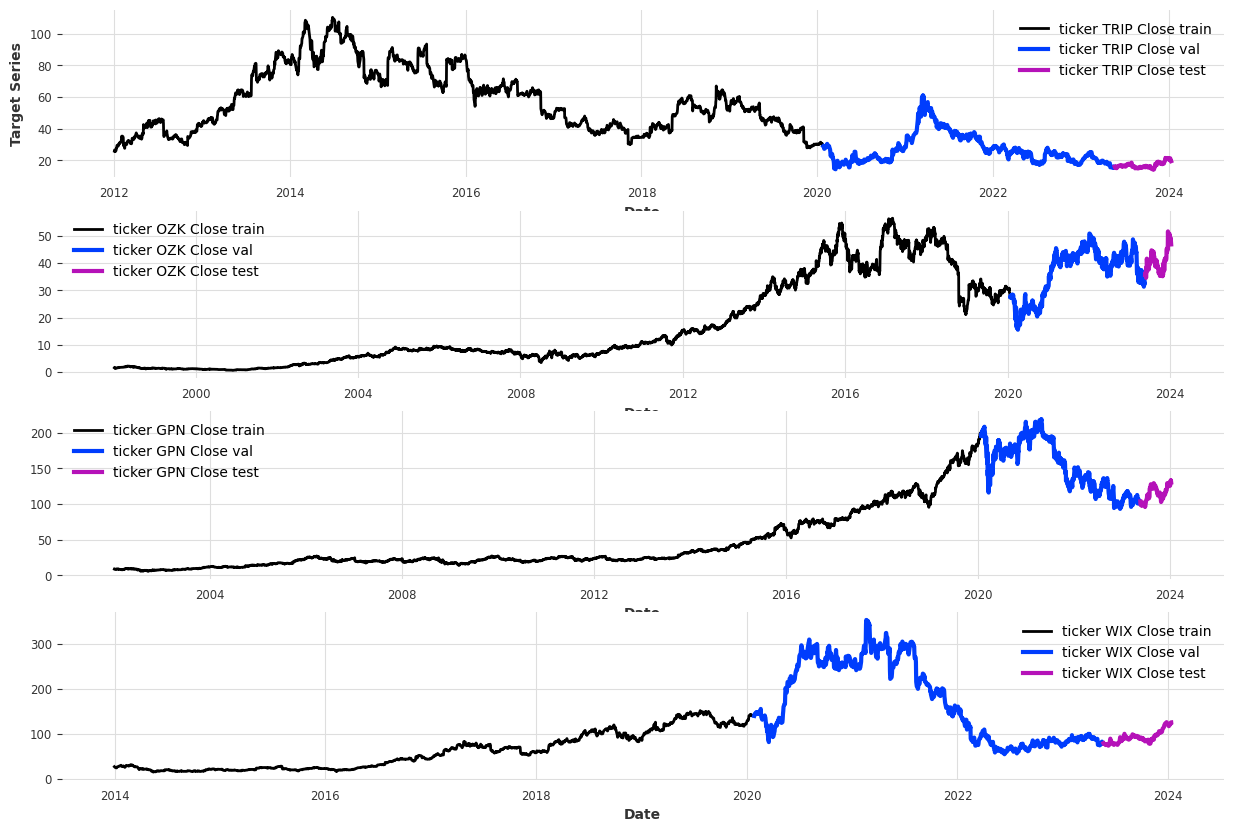

In [155]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(15, 10))
for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break
    train_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} train', ax=axes[i])
    val_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} val', lw=3, ax=axes[i])
    test_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} test', lw=3, ax=axes[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

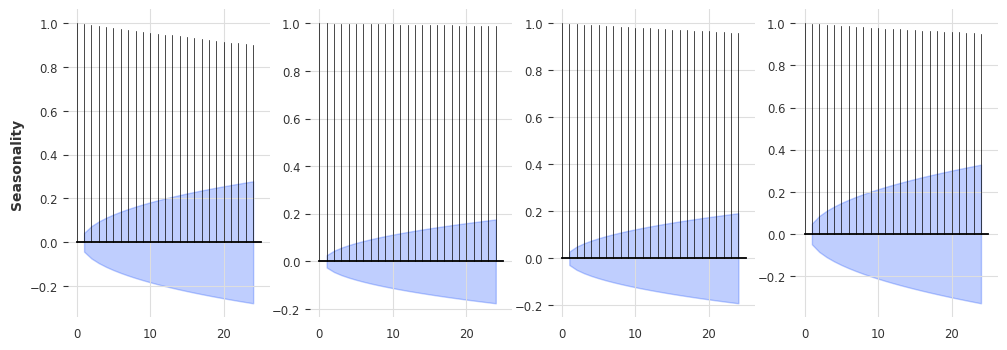

In [156]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i >= n_plot_samples:
        break
    plot_acf(train_series[t], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



## Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [157]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
# scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



Model hyperparameter selection

In [158]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 2.24e-4,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [159]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      add_encoders=None, # encoders,
      hidden_size=512,
      num_encoder_layers=2,
      num_decoder_layers=2,
      decoder_output_dim=32,
      temporal_decoder_hidden=64,
      dropout=0.2,
      use_layer_norm=True,
      use_reversible_instance_norm=True,
      n_epochs=n_epochs,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
      log_tensorboard=True,
      nr_epochs_val_period=2
  )
  


Loading saved model
Error loading saved model: [Errno 2] No such file or directory: 'data/canswim_model.pt'
Creating a new model


In [160]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [161]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_val_list))
target_test_list = [series for ticker, series in sorted(test_series.items())]
print(len(target_test_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
past_cov_val_list = [series for ticker, series in sorted(past_covariates_val.items())]
print(len(past_cov_val_list))
past_cov_test_list = [series for ticker, series in sorted(past_covariates_test.items())]
print(len(past_cov_test_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


9
9
9
9
9
9
9


In [162]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [163]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))

print(len(target_val_list[0].time_index))
print(len(past_cov_val_list[0].time_index))

print(len(target_test_list[0].time_index))
print(len(past_cov_test_list[0].time_index))

print(len(future_cov_list[0].time_index))


1323
1458
865
865
170
170
2358


In [164]:
target_train_list[0].pd_dataframe()

component,Close
Date,
2014-12-31,11.610000
2015-01-01,11.725000
2015-01-02,11.840000
2015-01-05,11.830000
2015-01-06,11.810000
...,...
2020-01-20,20.035000
2020-01-21,19.990000
2020-01-22,20.000000


In [165]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('2014-12-31 00:00:00'), Timestamp('2020-01-24 00:00:00'))

In [166]:
past_cov_list[0].pd_dataframe().columns

Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'eps', 'epsEstimated',
       'time', 'revenue', 'revenueEstimated',
       ...
       '^SPX_High', '^SPX_Low', '^SPX_Close', '^SPX_Adj Close', '^SPX_Volume',
       'DX-Y.NYB_Open', 'DX-Y.NYB_High', 'DX-Y.NYB_Low', 'DX-Y.NYB_Close',
       'DX-Y.NYB_Adj Close'],
      dtype='object', name='component', length=126)

In [167]:
past_cov_list[0].pd_dataframe()

component,Open,High,Low,Adj Close,Volume,eps,epsEstimated,time,revenue,revenueEstimated,...,^SPX_High,^SPX_Low,^SPX_Close,^SPX_Adj Close,^SPX_Volume,DX-Y.NYB_Open,DX-Y.NYB_High,DX-Y.NYB_Low,DX-Y.NYB_Close,DX-Y.NYB_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-25,7.000000,8.950000,6.670000,8.750000,4159700.0,-1.0,-0.11,1.0,-1.0,76770000.0,...,1960.829956,1947.489990,1959.530029,1959.530029,3.106710e+09,80.320000,80.349998,80.089996,80.220001,80.220001
2014-06-26,9.000000,11.070000,8.800000,10.010000,1412900.0,-1.0,-0.11,1.0,-1.0,76770000.0,...,1959.890015,1944.689941,1957.219971,1957.219971,2.778840e+09,80.220001,80.379997,80.139999,80.230003,80.230003
2014-06-27,10.250000,10.680000,9.960000,10.500000,395600.0,-1.0,-0.11,1.0,-1.0,76770000.0,...,1961.469971,1952.180054,1960.959961,1960.959961,4.290590e+09,80.209999,80.220001,80.010002,80.040001,80.040001
2014-06-30,10.000000,10.960000,9.750000,10.010000,183800.0,-1.0,-0.11,1.0,-1.0,76770000.0,...,1964.239990,1958.219971,1960.229980,1960.229980,3.037350e+09,80.010002,80.089996,79.760002,79.779999,79.779999
2014-07-01,9.900000,10.390000,9.490000,9.750000,204800.0,-1.0,-0.11,1.0,-1.0,76770000.0,...,1978.579956,1962.290039,1973.319946,1973.319946,3.188240e+09,79.790001,79.870003,79.739998,79.820000,79.820000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-20,20.099999,20.270000,19.935000,20.035000,192000.0,-1.0,0.05,1.0,-1.0,83383000.0,...,3329.834961,3317.735107,3325.205078,3325.205078,3.915530e+09,97.469997,97.660004,97.329998,97.570000,97.570000
2020-01-21,19.959999,20.299999,19.930000,19.990000,158100.0,-1.0,0.05,1.0,-1.0,83383000.0,...,3329.790039,3316.610107,3320.790039,3320.790039,4.104840e+09,97.629997,97.660004,97.389999,97.529999,97.529999
2020-01-22,20.170000,20.200001,19.920000,20.000000,117400.0,-1.0,0.05,1.0,-1.0,83383000.0,...,3337.770020,3320.040039,3321.750000,3321.750000,3.623780e+09,97.620003,97.690002,97.440002,97.529999,97.529999


In [168]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('2014-06-25 00:00:00'), Timestamp('2020-01-24 00:00:00'))

In [169]:
target_val_list[0].start_time(), target_val_list[0].end_time()

(Timestamp('2020-01-27 00:00:00'), Timestamp('2023-05-19 00:00:00'))

In [170]:
past_cov_val_list[0].start_time(), past_cov_val_list[0].end_time()

(Timestamp('2020-01-27 00:00:00'), Timestamp('2023-05-19 00:00:00'))

In [171]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays                               9.400000e+01
estimatedRevenueLow_p_1                2.303341e+11
estimatedRevenueHigh_p_1               2.439343e+11
estimatedRevenueAvg_p_1                2.373335e+11
estimatedEbitdaLow_p_1                 1.341294e+10
                                           ...     
numberAnalystEstimatedRevenue_p_2_1    2.195000e+04
numberAnalystsEstimatedEps_p_2_1       2.088500e+04
fiscalDateEnding_day_p_2_1             7.309800e+04
fiscalDateEnding_month_p_2_1           2.829600e+04
fiscalDateEnding_year_p_2_1            4.763207e+06
Length: 139, dtype: float64

In [172]:
future_cov_list[0].columns

Index(['holidays', 'estimatedRevenueLow_p_1', 'estimatedRevenueHigh_p_1',
       'estimatedRevenueAvg_p_1', 'estimatedEbitdaLow_p_1',
       'estimatedEbitdaHigh_p_1', 'estimatedEbitdaAvg_p_1',
       'estimatedEbitLow_p_1', 'estimatedEbitHigh_p_1', 'estimatedEbitAvg_p_1',
       ...
       'estimatedSgaExpenseHigh_p_2_1', 'estimatedSgaExpenseAvg_p_2_1',
       'estimatedEpsAvg_p_2_1', 'estimatedEpsHigh_p_2_1',
       'estimatedEpsLow_p_2_1', 'numberAnalystEstimatedRevenue_p_2_1',
       'numberAnalystsEstimatedEps_p_2_1', 'fiscalDateEnding_day_p_2_1',
       'fiscalDateEnding_month_p_2_1', 'fiscalDateEnding_year_p_2_1'],
      dtype='object', name='component', length=139)

In [173]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('2014-12-31 00:00:00'), Timestamp('2024-01-12 00:00:00'))

### Run model training loop

In [174]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, 
          val_series=target_val_list, val_past_covariates=past_cov_val_list, val_future_covariates=future_cov_list,
          verbose=True, num_loader_workers=10, )
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 67.6 K
5 | future_cov_projection | _ResidualBlock   | 74.3 K
6 | encoders              | Sequential       | 5.9 M 
7 | decoders              | Sequential       | 10.7 M
8 | temporal_decoder      | _ResidualBlock   | 16.7 K
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
16.9 M    Trainable params
0         Non-trainable params
16.9 M    Total params
67.603    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

### Save model checkpoint

In [ ]:
# save model checkpoint
model.save(saved_model_name)


In [ ]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
# pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

## Test Model Forecasting

In [ ]:
# pred[0]

In [ ]:
# pred[0].gaps()

In [ ]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

### Plot several forecasts at various future starting points

In [ ]:
import matplotlib.dates as mdates

# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))


def get_pred_list(pred_start=None):
    pred_list = []
    for t, target in sorted(target_series.items()):
        pred_series = target.slice(target.start_time(), pred_start-pd.Timedelta(days=1))
        pred_list.append(pred_series)
    return pred_list


def get_past_covs(start=None):
    past_cov_list = []
    for t, past_cov in sorted(past_covariates.items()):
        past_covs_sliced = past_cov.slice(past_cov.start_time(), pred_start-pd.Timedelta(days=1))
        past_cov_list.append(past_covs_sliced)
    return past_cov_list


def plot_pred(pred_list=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    pred = model.predict(pred_horizon, series=pred_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            # tsliced = target_series[t]
            # actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
            # ax = actual[t].plot(label='actual', ax=axes[i])
            ax = pred[i].plot(label=f'forecast {pred_list[0].end_time()} + {pred_horizon}', linewidth=2, ax=axes[i])
            #pred2.plot(label=f'forecast {pred2_series.end_time()} + {pred_horizon}')
            plt.legend()
            # Major ticks every half year, minor ticks every month,
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.grid(True)
            ax.set_ylabel(f'{t}')


def plot_actual():
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            tsliced = target_series[t]
            actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
            ax = actual[t].plot(label='actual', linewidth=1, ax=axes[i])

plot_actual()

# show predictions at several points in time over the validation set
for w in range(5):
    pred_start = val_start + pd.Timedelta(days=w*pred_horizon)
    pred_list = get_pred_list(pred_start)
    past_cov_list = get_past_covs(pred_start)
    # print(f'pred_list: \n{pred_list}')
    plot_pred(pred_list=pred_list, past_cov_list=past_cov_list)



### Backtest Model


In [ ]:
# Backtest model on the full range of test data
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          overlap_end=True,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [ ]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=120)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=targets_list[:n_plot_samples], start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list[:n_plot_samples], future_covariates=future_cov_list[:n_plot_samples])


In [ ]:

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t].plot(label='actual', ax=axes[i])
        backtest[i].plot(label=f'backtest (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes[i])
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')



In [ ]:
print('Backtest RMSE = {}'.format(rmse(target_train_list[:n_plot_samples], backtest)))
